In [1]:
# === 1. Imports & setup ===
import warnings; warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# grafici: u daljem kodu koristimo *matplotlib* (bez seaborn-a) da bude konzistentno
import matplotlib.pyplot as plt

from scipy.stats import normaltest, anderson

RANDOM_STATE = 56
pd.set_option("display.max_columns", None)


In [16]:
# === 2. Učitavanje podataka ===
CSV_PATH = r"G:\Data setovi NM\continuous dataset.csv"
df = pd.read_csv(CSV_PATH, parse_dates=["datetime"])

In [19]:
pd.set_option('display.max_columns', None)
df.head(5)

datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
0 2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
1 2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2 2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
3 2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
4 2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

     T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  QV2M_dav   TQL_dav  \
0  23.482446  0.017272  0.001855  10.328949  22.662134  0.016562  0.096100   
1  23.399255  0.017265  0.001327  10.681517  22.578943  0.016509  0.087646   
2  23.343530  0.017211  0.001428  10.874924  22.531030  0.016479  0.078735   
3  23.238794  0.017128  0.002599  10.518620  22.512231  0.016487  0.068390   
4  23.075403  0.017059  0.001729   9.733589  22.481653  0.016456  0.064362   

    W2M_dav  Holiday_ID  holiday  school  
0  5.364148           0        0       0  
1  5.572471           0        0       0  
2  5.871184           0        0       0  
3  5.883621           0        0       0  
4  5.611724           0        0       0

In [17]:
print("Dimenzije (redovi, kolone):", df.shape)

Dimenzije (redovi, kolone): (48048, 17)


In [11]:
df.columns

Index(['datetime', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
       'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav',
       'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [13]:
# Tipovi kolona
display(df.dtypes.to_frame("dtype"))


dtype
datetime    datetime64[ns]
nat_demand         float64
T2M_toc            float64
QV2M_toc           float64
TQL_toc            float64
W2M_toc            float64
T2M_san            float64
QV2M_san           float64
TQL_san            float64
W2M_san            float64
T2M_dav            float64
QV2M_dav           float64
TQL_dav            float64
W2M_dav            float64
Holiday_ID           int64
holiday              int64
school               int64

In [4]:
# === 3. Nedostajuće vrednosti ===
col_missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
print("Procenat nedostajućih vrednosti po kolonama (%):")
display(col_missing_pct.to_frame("missing_%"))

row_missing_pct = df.isnull().mean(axis=1) * 100
print("Redovi sa nedostajućim vrednostima (broj):", (row_missing_pct > 0).sum())

# === 5. Duplikati ===
dup_count = df.duplicated().sum()
print("Broj dupliranih redova:", dup_count)

# === 6. Vremenski opseg (pošto ima 'datetime') ===
print("Min datetime:", df["datetime"].min(), "| Max datetime:", df["datetime"].max())
df["_year"] = df["datetime"].dt.year
display(df["_year"].value_counts().sort_index().to_frame("broj_opažanja_po_godini"))
df.drop(columns=["_year"], inplace=True)


Procenat nedostajućih vrednosti po kolonama (%):


missing_%
datetime          0.0
nat_demand        0.0
T2M_toc           0.0
QV2M_toc          0.0
TQL_toc           0.0
W2M_toc           0.0
T2M_san           0.0
QV2M_san          0.0
TQL_san           0.0
W2M_san           0.0
T2M_dav           0.0
QV2M_dav          0.0
TQL_dav           0.0
W2M_dav           0.0
Holiday_ID        0.0
holiday           0.0
school            0.0

Redovi sa nedostajućim vrednostima (broj): 0
Broj dupliranih redova: 0
Min datetime: 2015-01-03 01:00:00 | Max datetime: 2020-06-27 00:00:00


broj_opažanja_po_godini
_year                         
2015                      8711
2016                      8784
2017                      8760
2018                      8760
2019                      8760
2020                      4273

In [5]:
# === 4. Provera standardizacije numeričkih kolona ===
def check_standardization(frame, cols, mean_tol=0.1, std_tol=0.1):
    stats = []
    for c in cols:
        m = frame[c].mean()
        s = frame[c].std(ddof=0)
        is_std = (abs(m) <= mean_tol) and (abs(s - 1) <= std_tol)
        stats.append({"kolona": c, "mean": m, "std": s, "≈standardizovana?": is_std})
    return pd.DataFrame(stats).set_index("kolona").sort_index()

std_report = check_standardization(df, num_features)
display(std_report)


mean       std  ≈standardizovana?
kolona                                          
QV2M_dav   0.016867  0.001584              False
QV2M_san   0.017844  0.001889              False
QV2M_toc   0.018313  0.001607              False
T2M_dav   24.719513  2.413994              False
T2M_san   26.921023  3.018097              False
T2M_toc   27.399111  1.675445              False
TQL_dav    0.144681  0.087898              False
TQL_san    0.106265  0.086292              False
TQL_toc    0.079979  0.065589              False
W2M_dav    3.567589  1.710504              False
W2M_san    7.046675  4.103669              False
W2M_toc   13.391049  7.295426              False

In [33]:
# Odaberi ulaze i cilj
target = 'nat_demand'

In [34]:
# Numerički atributi
num_features = ['T2M_toc','QV2M_toc','TQL_toc','W2M_toc',
                'T2M_san','QV2M_san','TQL_san','W2M_san',
                'T2M_dav','QV2M_dav','TQL_dav','W2M_dav']
# Kategorijski atributi
cat_features = ['Holiday_ID','holiday','school']

In [35]:
X = df[num_features + cat_features]
y = df[target]

Deskriptivne statistike:
                    mean       median      variance
T2M_toc       27.399111    27.118051      2.807174
QV2M_toc       0.018313     0.018590      0.000003
TQL_toc        0.079979     0.065201      0.004302
W2M_toc       13.391049    12.182103     53.224353
T2M_san       26.921023    26.167352      9.109101
QV2M_san       0.017844     0.018351      0.000004
TQL_san        0.106265     0.085968      0.007446
W2M_san        7.046675     5.992762     16.840447
T2M_dav       24.719513    24.001718      5.827489
QV2M_dav       0.016867     0.017167      0.000003
TQL_dav        0.144681     0.130188      0.007726
W2M_dav        3.567589     3.413994      2.925884
nat_demand  1182.868647  1168.427700  36890.460936


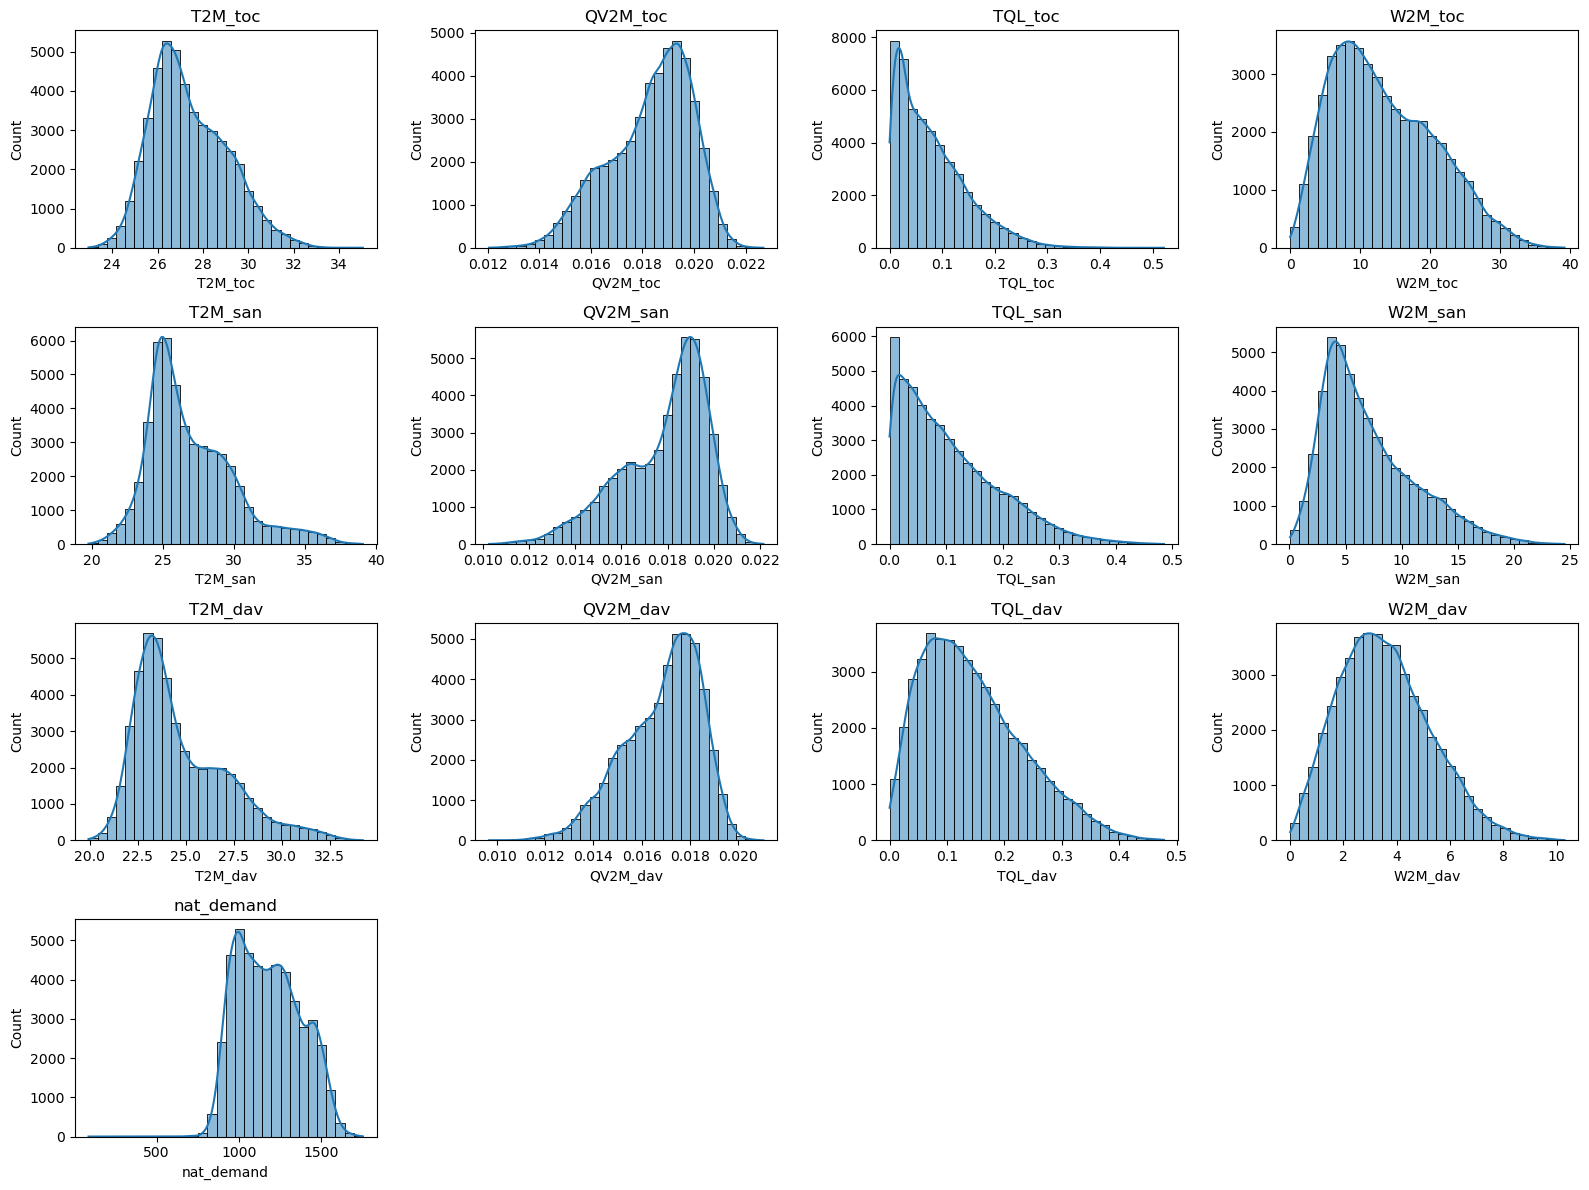


Test normalnosti:
         Kolona   Shapiro-W p  D'Agostino p  Anderson stat  Anderson 5% cv  \
0      T2M_toc  1.485682e-61           0.0     343.231033           0.787   
1     QV2M_toc  7.360270e-69           0.0     493.341971           0.787   
2      TQL_toc  5.937516e-94           0.0    1115.361487           0.787   
3      W2M_toc  8.621203e-71           0.0     469.909273           0.787   
4      T2M_san  2.643906e-83           0.0     843.978014           0.787   
5     QV2M_san  1.590151e-82           0.0     934.503727           0.787   
6      TQL_san  8.129227e-92           0.0    1100.299643           0.787   
7      W2M_san  1.133194e-87           0.0    1055.068720           0.787   
8      T2M_dav  1.057521e-88           0.0    1161.361313           0.787   
9     QV2M_dav  1.121153e-69           0.0     480.830832           0.787   
10     TQL_dav  1.391377e-75           0.0     525.415002           0.787   
11     W2M_dav  1.776256e-56           0.0     165.39625

In [36]:
# === 5. Deskriptivne statistike ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, anderson

# Numeričke kolone + cilj
num_cols = num_features + ['nat_demand']

# === 1. Deskriptivne statistike ===
desc_stats = df[num_cols].agg(['mean','median','var']).T
desc_stats = desc_stats.rename(columns={'var':'variance'})
print("Deskriptivne statistike:\n", desc_stats)

# === 2. Histogrami ===
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

# === 3. Testiranje normalnosti ===
normality_results = []

for col in num_cols:
    data = df[col].dropna()
    
    # Shapiro-Wilk
    shapiro_p = shapiro(data)[1]
    # D'Agostino & Pearson
    dagostino_p = normaltest(data)[1]
    # Anderson-Darling
    ad_stat = anderson(data).statistic
    ad_5cv = anderson(data).critical_values[2]  # 5% kritična vrednost
    
    normal = (shapiro_p > 0.05) and (dagostino_p > 0.05) and (ad_stat < ad_5cv)
    
    normality_results.append({
        'Kolona': col,
        'Shapiro-W p': shapiro_p,
        "D'Agostino p": dagostino_p,
        'Anderson stat': ad_stat,
        'Anderson 5% cv': ad_5cv,
        'Normalnost?': normal
    })

normality_df = pd.DataFrame(normality_results)
print("\nTest normalnosti:\n", normality_df)



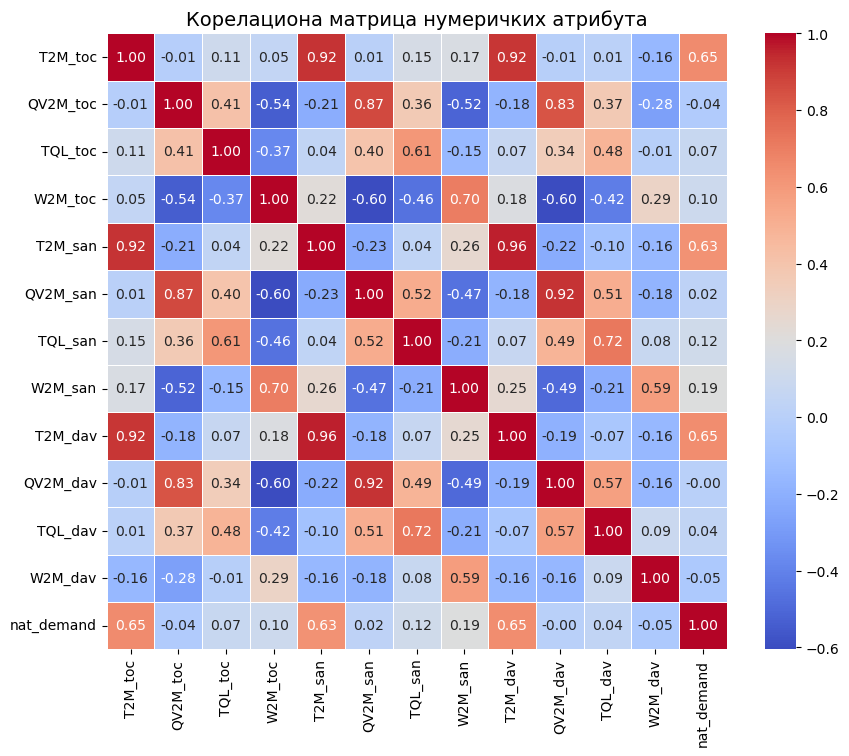

In [37]:
# === 6. Korelaciona matrica ===

plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корелациона матрица нумеричких атрибута", fontsize=14)
plt.show()


Najkorelisanije promenljive sa nat_demand: ['T2M_toc', 'T2M_dav', 'T2M_san', 'W2M_san', 'TQL_san']


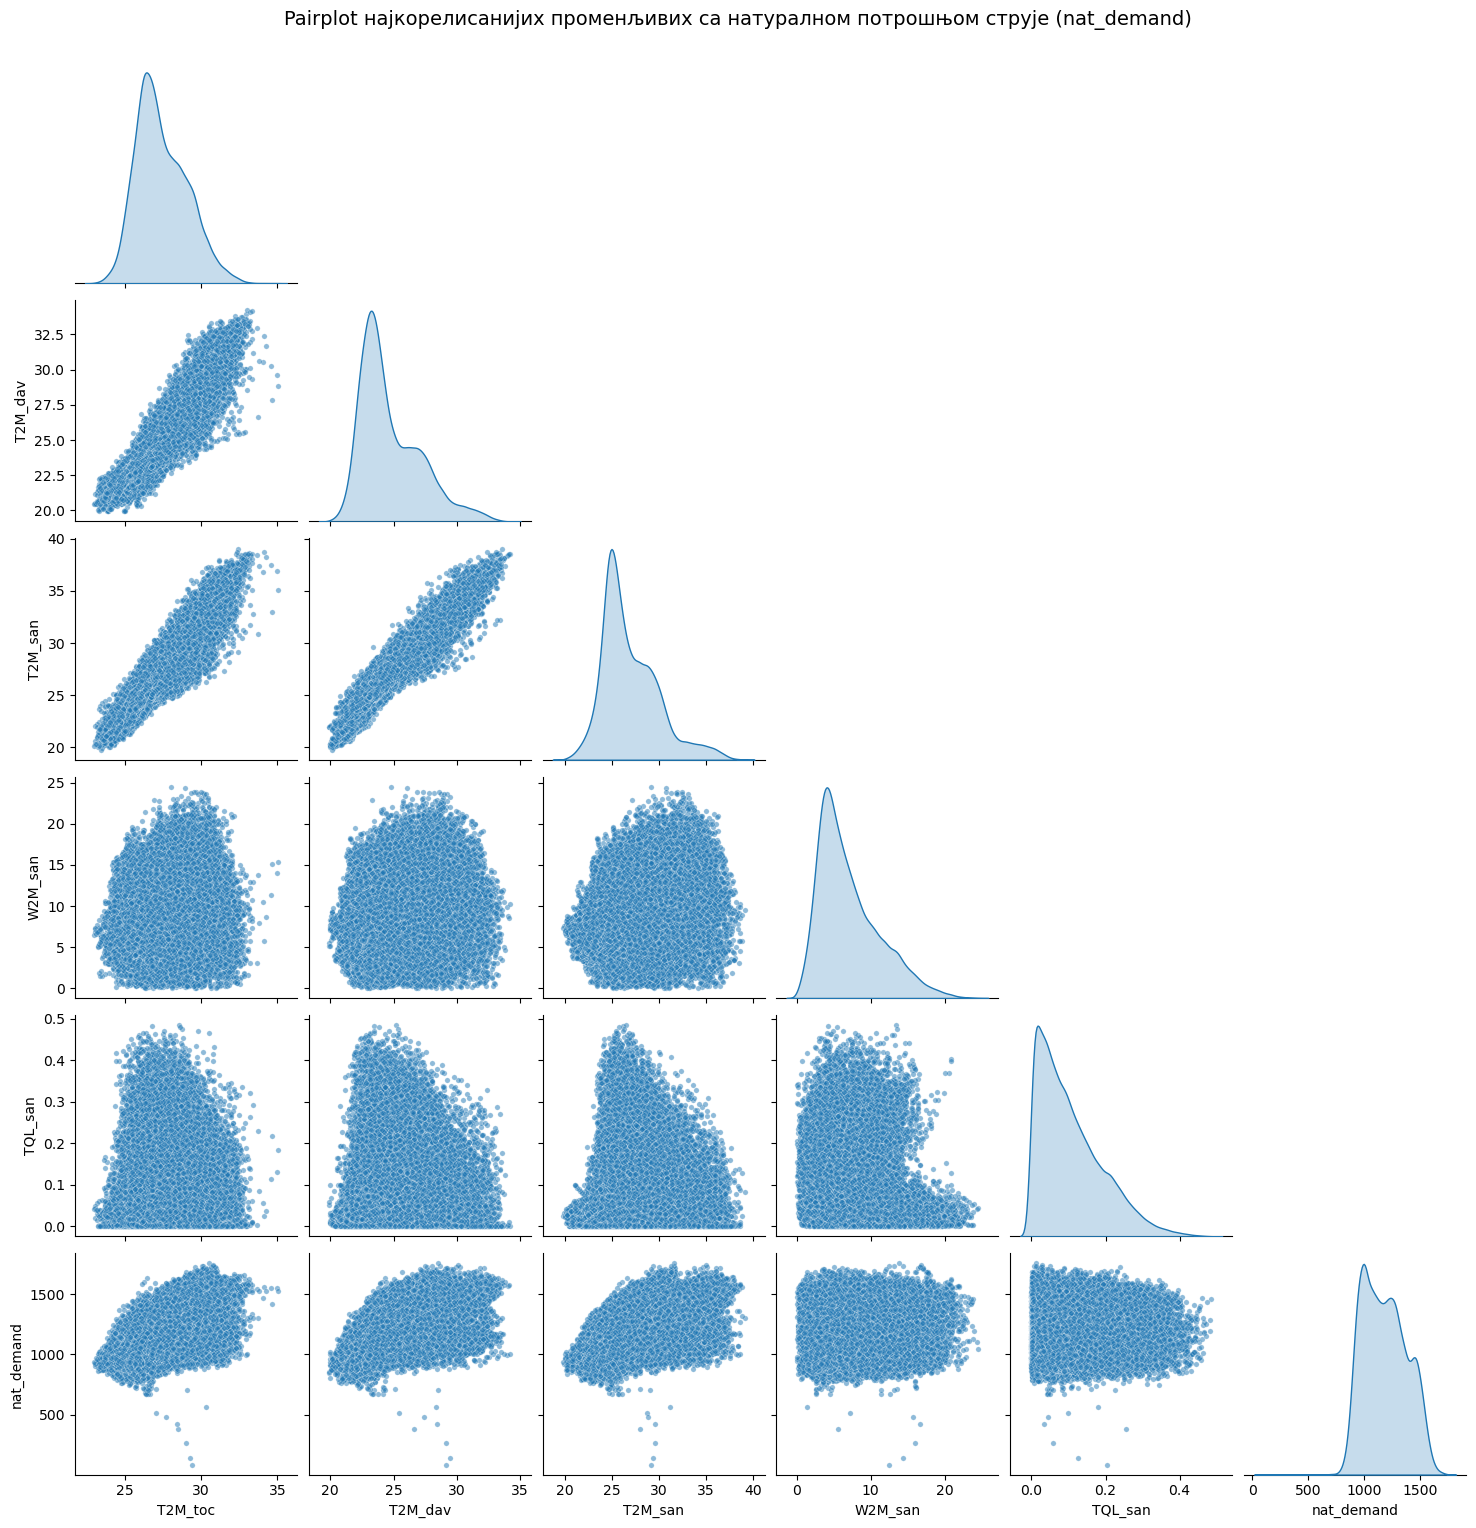

In [25]:
# === 7. Pairplot najkorelisanijih promenljivих са nat_demand ===

# Izračunaj korelacije
corr_matrix = df[num_cols].corr()

# Odredi 5 atributa sa najjačom korelacijom (po apsolutnoj vrednosti)
top_corr = (
    corr_matrix["nat_demand"]
    .drop("nat_demand")
    .abs()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

print("Najkorelisanije promenljive sa nat_demand:", top_corr)

# Subset podataka za pairplot
subset_cols = top_corr + ["nat_demand"]
sns.pairplot(df[subset_cols], diag_kind="kde", corner=True, plot_kws={'alpha':0.5, 's':15, 'color':'#1f77b4'})

plt.suptitle("Pairplot најкoрелисанијих променљивих са натуралном потрошњом струје (nat_demand)", y=1.02, fontsize=14)
plt.show()


In [38]:
# === 8. Podela na trening i test skup ===

from sklearn.model_selection import train_test_split

# 80% podataka koristi se za treniranje, 20% za testiranje
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=56
)

print("Dimenzije trening i test skupa:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")


Dimenzije trening i test skupa:
X_train: (38438, 15) | y_train: (38438,)
X_test:  (9610, 15)  | y_test:  (9610,)


In [39]:
# === 9. Preprocessing: standardizacija i kodiranje kategorijskih atributa ===

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# StandardScaler za numeričke kolone, OneHotEncoder za kategorijske
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features)
])

# Primeni transformaciju na trening i test skup
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)

print("Oblik transformisanog trening skupa:", X_train_transformed.shape)
print("Oblik transformisanog test skupa:", X_test_transformed.shape)


Oblik transformisanog trening skupa: (38438, 39)
Oblik transformisanog test skupa: (9610, 39)


In [40]:
# === 10. Random Forest Regressor ===
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Kreiranje pipeline-a: preprocesiranje + model
rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=200,
        random_state=56,
        n_jobs=-1
    ))
])

# Treniranje modela
rf_pipeline.fit(X_train, y_train)

# Predikcija na test skupu
y_pred_rf = rf_pipeline.predict(X_test)

# === Evaluacija modela ===
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("Rezultati Random Forest modela:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")


Rezultati Random Forest modela:
RMSE: 103.755
MAE:  79.806
R²:   0.708



Najznačajnije promenljive za Random Forest:


Feature  Importance
8        T2M_dav    0.516095
0        T2M_toc    0.053943
1       QV2M_toc    0.042632
2        TQL_toc    0.042483
7        W2M_san    0.041100
3        W2M_toc    0.040641
5       QV2M_san    0.038521
4        T2M_san    0.038338
10       TQL_dav    0.035575
6        TQL_san    0.034647
9       QV2M_dav    0.032930
11       W2M_dav    0.031953
36     holiday_1    0.013773
12  Holiday_ID_0    0.012010
35     holiday_0    0.009452

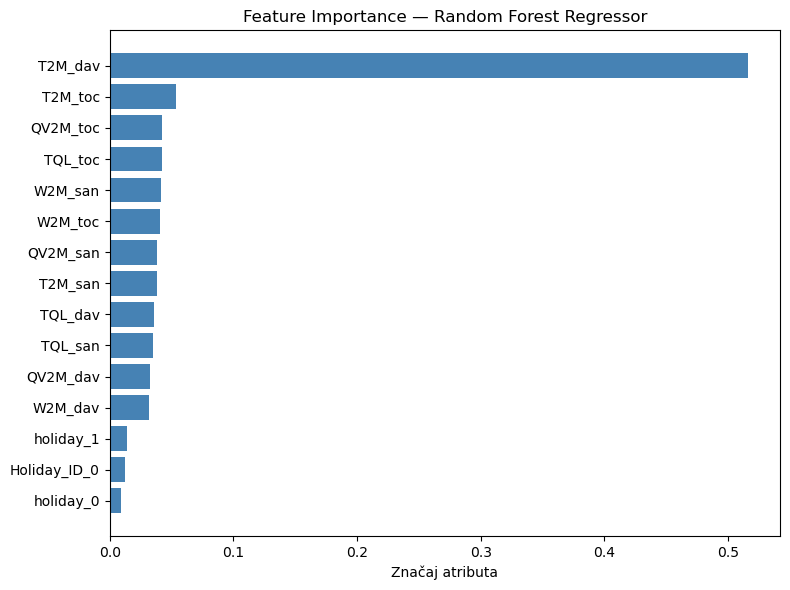

In [41]:
# === 11. Feature importance ===
rf_model = rf_pipeline.named_steps['rf']

# Imena kolona iz preprocesora
feature_names_num = num_features
feature_names_cat = rf_pipeline.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(cat_features)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Izračunavanje značaja atributa
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

print("\nNajznačajnije promenljive za Random Forest:")
display(feat_imp.head(15))

# Grafički prikaz top 15 atributa
plt.figure(figsize=(8, 6))
plt.barh(feat_imp['Feature'].head(15)[::-1], feat_imp['Importance'].head(15)[::-1], color='steelblue')
plt.xlabel("Značaj atributa")
plt.title("Feature Importance — Random Forest Regressor")
plt.tight_layout()
plt.show()


In [42]:
# === 12. XGBoost Regressor ===

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Kreiranje pipeline-a: preprocesiranje + XGBoost model
xgb_pipeline = Pipeline([
    ('prep', preprocessor),
    ('xgb', XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        random_state=56,
        n_jobs=-1
    ))
])

# Treniranje modela
xgb_pipeline.fit(X_train, y_train)

# Predikcija
y_pred_xgb = xgb_pipeline.predict(X_test)

# === Evaluacija modela ===
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Rezultati XGBoost modela:")
print(f"RMSE: {rmse_xgb:.3f}")
print(f"MAE:  {mae_xgb:.3f}")
print(f"R²:   {r2_xgb:.3f}")


Rezultati XGBoost modela:
RMSE: 111.151
MAE:  86.743
R²:   0.665



Najznačajnije promenljive za XGBoost:


Feature  Importance
8         T2M_dav    0.486164
12   Holiday_ID_0    0.140040
25  Holiday_ID_13    0.026950
37       school_0    0.024872
0         T2M_toc    0.024175
4         T2M_san    0.024067
19   Holiday_ID_7    0.021303
20   Holiday_ID_8    0.020009
18   Holiday_ID_6    0.016632
32  Holiday_ID_20    0.013680
7         W2M_san    0.012151
13   Holiday_ID_1    0.012032
1        QV2M_toc    0.010627
34  Holiday_ID_22    0.010278
5        QV2M_san    0.010190

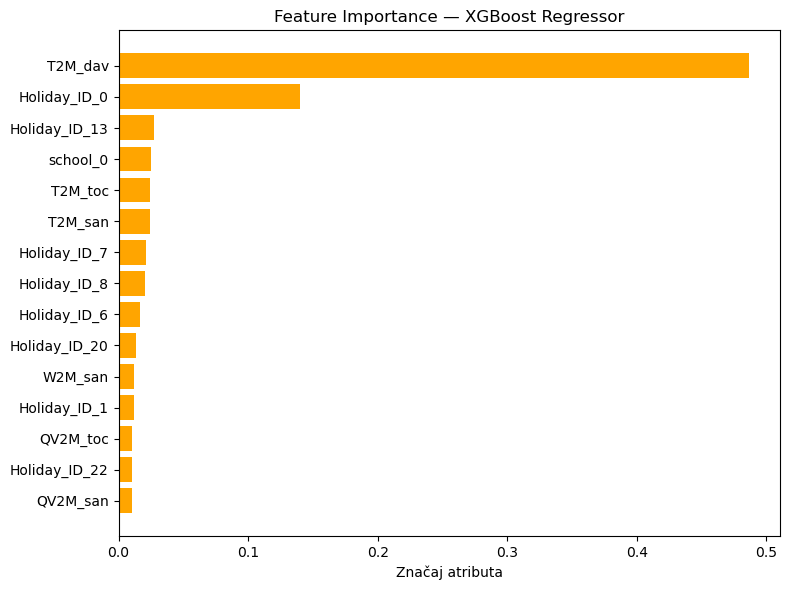

In [43]:
# === 13. Feature importance (XGBoost) ===
xgb_model = xgb_pipeline.named_steps['xgb']

# Imena atributa iz preprocesora
feature_names_num = num_features
feature_names_cat = xgb_pipeline.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(cat_features)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Važnost atributa
importances_xgb = xgb_model.feature_importances_

feat_imp_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
feat_imp_xgb = feat_imp_xgb.sort_values(by='Importance', ascending=False)

print("\nNajznačajnije promenljive za XGBoost:")
display(feat_imp_xgb.head(15))

# Grafički prikaz top 15 atributa
plt.figure(figsize=(8, 6))
plt.barh(feat_imp_xgb['Feature'].head(15)[::-1], feat_imp_xgb['Importance'].head(15)[::-1], color='orange')
plt.xlabel("Značaj atributa")
plt.title("Feature Importance — XGBoost Regressor")
plt.tight_layout()
plt.show()


In [48]:
# === 14. Neuronska mreža (MLP Regressor) ===
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Kreiranje pipeline-a: preprocesiranje + neuronska mreža
mlp_pipeline = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        random_state=56
    ))
])

# Treniranje modela
mlp_pipeline.fit(X_train, y_train)

# Predikcija
y_pred_mlp = mlp_pipeline.predict(X_test)

# === Evaluacija modela ===
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("Rezultati MLP modela:")
print(f"RMSE: {rmse_mlp:.3f}")
print(f"MAE:  {mae_mlp:.3f}")
print(f"R²:   {r2_mlp:.3f}")


Rezultati MLP modela:
RMSE: 116.339
MAE:  91.453
R²:   0.633


In [59]:
# === 15. Stacking Regressor (kombinacija RF + XGB + MLP) ===
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Kreiramo bazne modele (bez tuninga, kao i ostali)
rf_base = rf_pipeline
xgb_base = xgb_pipeline
mlp_base = mlp_pipeline

# Definišemo stacking regressor
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('mlp', mlp_base)
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

# Treniranje stacking modela
stacking_model.fit(X_train, y_train)

# Predikcija
y_pred_stack = stacking_model.predict(X_test)

# Evaluacija
mse_stack = mean_squared_error(y_test, y_pred_stack)
rmse_stack = np.sqrt(mse_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print("=== Stacking Regressor ===")
print(f"RMSE: {rmse_stack:.3f}")
print(f"MAE:  {mae_stack:.3f}")
print(f"R²:   {r2_stack:.3f}")


=== Stacking Regressor ===
RMSE: 103.064
MAE:  77.735
R²:   0.712


Model        RMSE        MAE        R²
0  Random Forest  103.754853  79.805963  0.708111
1        XGBoost  111.151192  86.742717  0.665012
2            MLP  116.338992  91.452862  0.633012
3       Stacking  103.064452  77.734529  0.711983

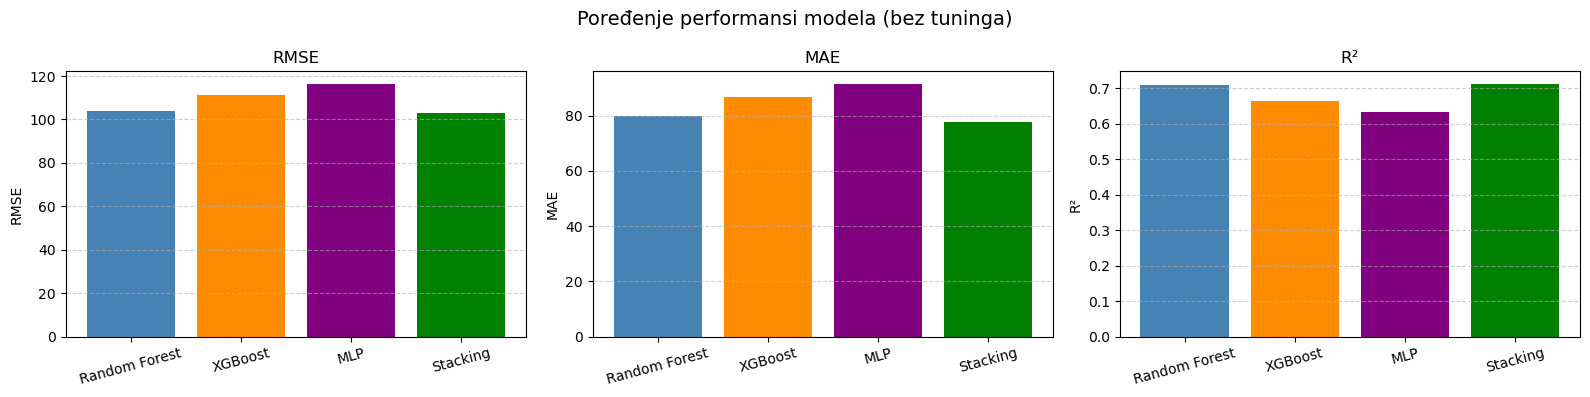

In [61]:
# === 16. Poređenje performansi modela (RF, XGB, MLP, Stacking) ===

# Kreiranje DataFrame-a sa metrikama
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'MLP', 'Stacking'],
    'RMSE':  [rmse, rmse_xgb, rmse_mlp, rmse_stack],
    'MAE':   [mae, mae_xgb, mae_mlp, mae_stack],
    'R²':    [r2, r2_xgb, r2_mlp, r2_stack]
})

display(results_df)

# === Grafički prikaz poređenja ===
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

metrics = ['RMSE', 'MAE', 'R²']
colors = ['steelblue', 'darkorange', 'purple', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric], color=colors)
    axes[i].set_title(metric, fontsize=12)
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    axes[i].tick_params(axis='x', rotation=15)

plt.suptitle("Poređenje performansi modela (bez tuninga)", fontsize=14)
plt.tight_layout()
plt.show()


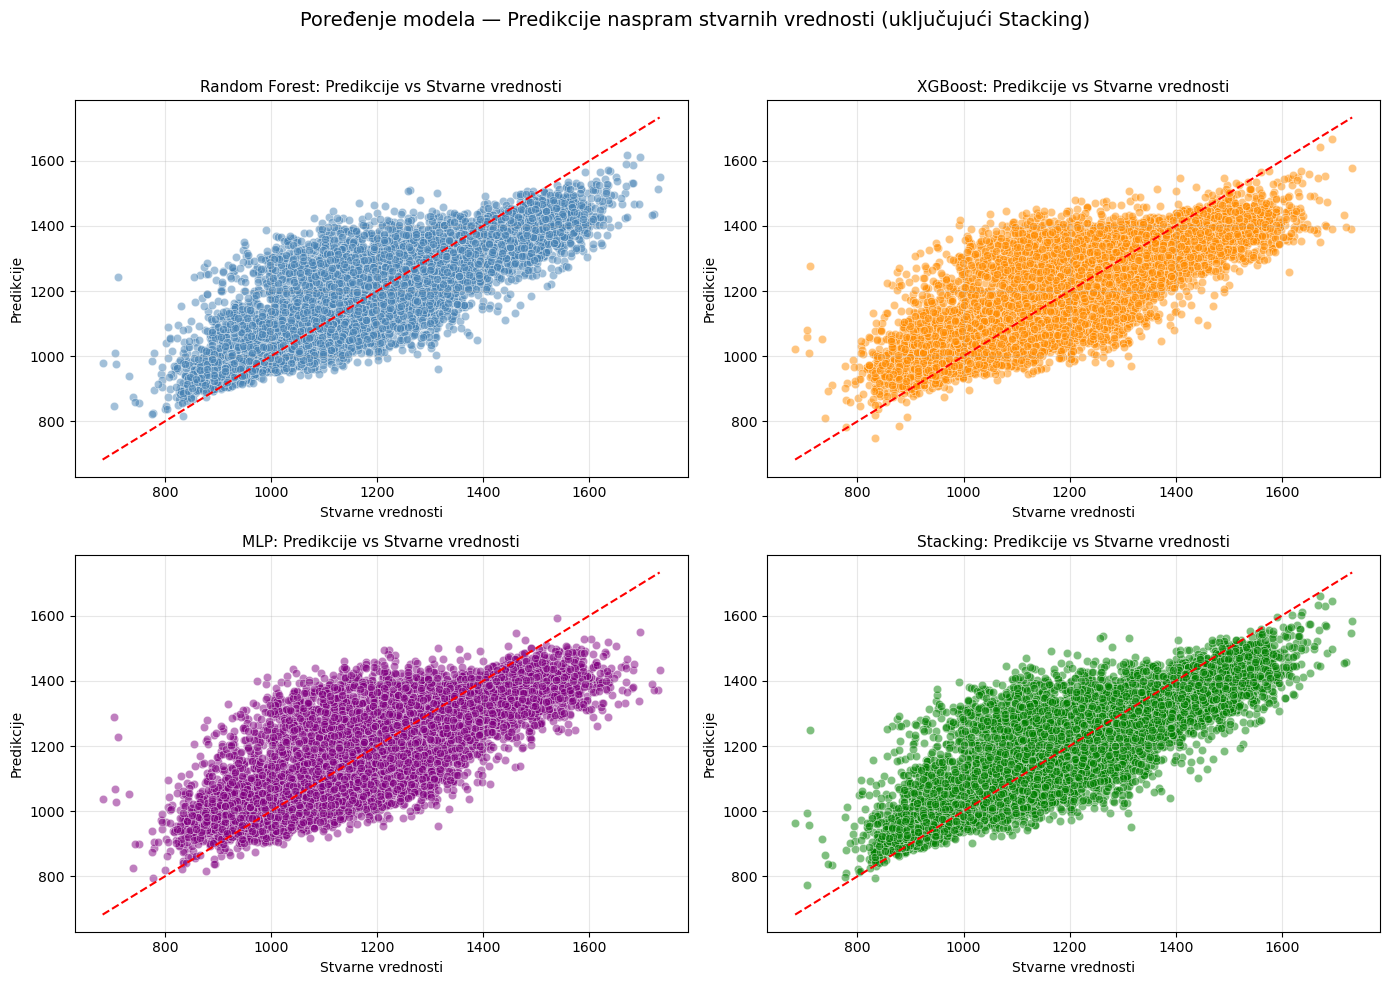

In [63]:
# === 17. Poređenje: Predikcije vs Stvarne vrednosti (RF, XGB, MLP, Stacking) — raspored 2x2 ===

import matplotlib.pyplot as plt
import seaborn as sns

# Priprema figure 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()  # lakši pristup putem indeksa

# Podaci za prikaz
models = [
    ("Random Forest", y_pred_rf, 'steelblue'),
    ("XGBoost", y_pred_xgb, 'darkorange'),
    ("MLP", y_pred_mlp, 'purple'),
    ("Stacking", y_pred_stack, 'green')
]

# Crtanje 4 grafa
for i, (title, preds, color) in enumerate(models):
    sns.scatterplot(x=y_test, y=preds, alpha=0.5, color=color, ax=axes[i])
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[i].set_title(f"{title}: Predikcije vs Stvarne vrednosti", fontsize=11)
    axes[i].set_xlabel("Stvarne vrednosti")
    axes[i].set_ylabel("Predikcije")
    axes[i].grid(alpha=0.3)

plt.suptitle("Poređenje modela — Predikcije naspram stvarnih vrednosti (uključujući Stacking)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


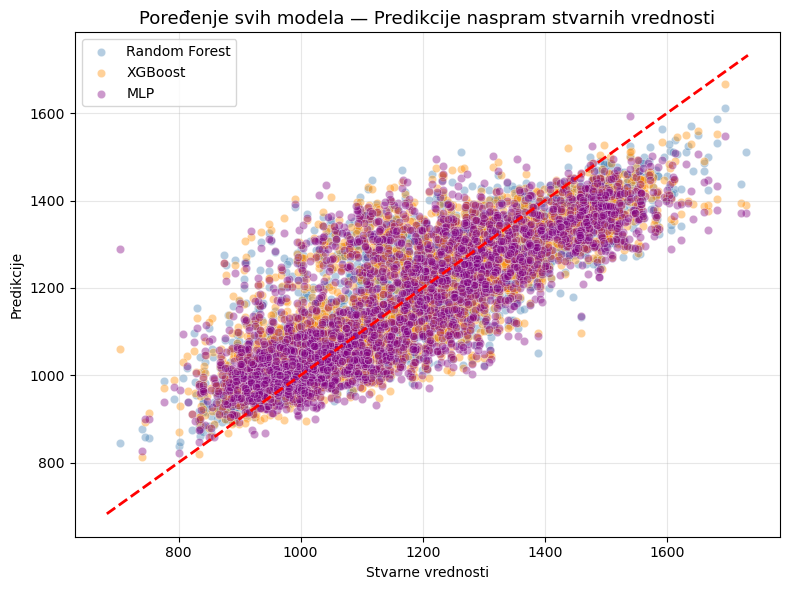

In [51]:
# === 18. Zajednički scatter grafikon: sve tri metode na jednom plotu ===

plt.figure(figsize=(8, 6))

# Nacrtaj tačke za svaki model (ograničene da ne preopterete prikaz, npr. prvih 3000 uzoraka)
sample_n = min(len(y_test), 3000)
sns.scatterplot(x=y_test[:sample_n], y=y_pred_rf[:sample_n], alpha=0.4, label='Random Forest', color='steelblue')
sns.scatterplot(x=y_test[:sample_n], y=y_pred_xgb[:sample_n], alpha=0.4, label='XGBoost', color='darkorange')
sns.scatterplot(x=y_test[:sample_n], y=y_pred_mlp[:sample_n], alpha=0.4, label='MLP', color='purple')

# Dijagonala (idealna tačnost)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title("Poređenje svih modela — Predikcije naspram stvarnih vrednosti", fontsize=13)
plt.xlabel("Stvarne vrednosti")
plt.ylabel("Predikcije")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


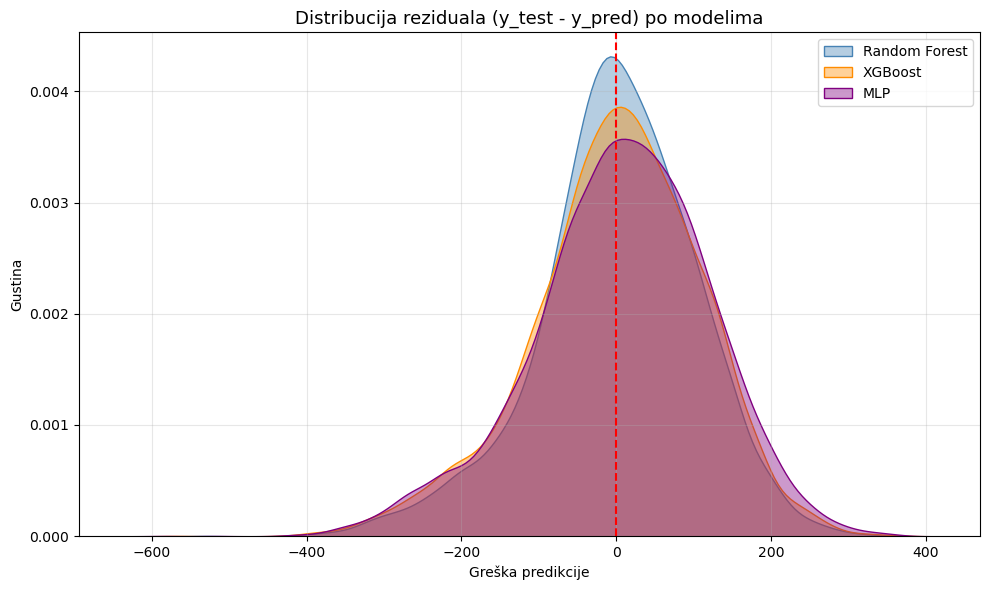

In [65]:
# === 19. Analiza reziduala (grešaka) po modelima ===
import seaborn as sns
import matplotlib.pyplot as plt

# Izračunavanje reziduala (stvarno - predviđeno)
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb
residuals_mlp = y_test - y_pred_mlp

# Prikaz histograma i KDE distribucije grešaka
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_rf, label='Random Forest', fill=True, alpha=0.4, color='steelblue')
sns.kdeplot(residuals_xgb, label='XGBoost', fill=True, alpha=0.4, color='darkorange')
sns.kdeplot(residuals_mlp, label='MLP', fill=True, alpha=0.4, color='purple')

plt.axvline(0, color='red', linestyle='--', lw=1.5)
plt.title("Distribucija reziduala (y_test - y_pred) po modelima", fontsize=13)
plt.xlabel("Greška predikcije")
plt.ylabel("Gustina")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


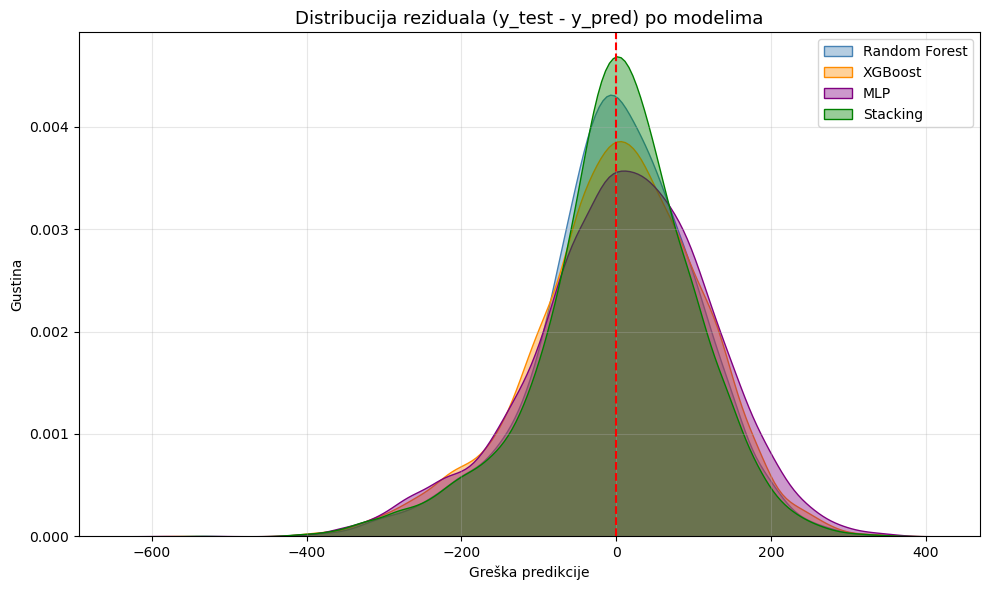

In [66]:
# === 20. Analiza reziduala (grešaka) po modelima, uključujući Stacking ===

import seaborn as sns
import matplotlib.pyplot as plt

# Izračunavanje reziduala (stvarno - predviđeno)
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb
residuals_mlp = y_test - y_pred_mlp
residuals_stack = y_test - y_pred_stack

# Prikaz histograma i KDE distribucije grešaka
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_rf, label='Random Forest', fill=True, alpha=0.4, color='steelblue')
sns.kdeplot(residuals_xgb, label='XGBoost', fill=True, alpha=0.4, color='darkorange')
sns.kdeplot(residuals_mlp, label='MLP', fill=True, alpha=0.4, color='purple')
sns.kdeplot(residuals_stack, label='Stacking', fill=True, alpha=0.4, color='green')

plt.axvline(0, color='red', linestyle='--', lw=1.5)
plt.title("Distribucija reziduala (y_test - y_pred) po modelima", fontsize=13)
plt.xlabel("Greška predikcije")
plt.ylabel("Gustina")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


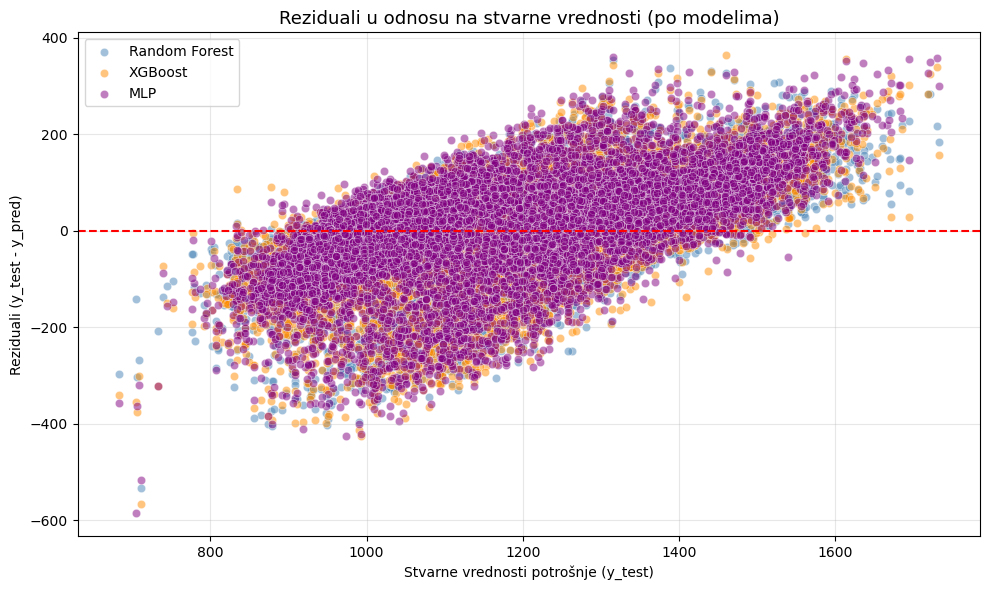

In [53]:
# === 21. Reziduali u odnosu na stvarne vrednosti (scatter) ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Scatter za svaki model
sns.scatterplot(x=y_test, y=residuals_rf, alpha=0.5, label='Random Forest', color='steelblue')
sns.scatterplot(x=y_test, y=residuals_xgb, alpha=0.5, label='XGBoost', color='darkorange')
sns.scatterplot(x=y_test, y=residuals_mlp, alpha=0.5, label='MLP', color='purple')

# Linija greške = 0
plt.axhline(0, color='red', linestyle='--', lw=1.5)

plt.title("Reziduali u odnosu na stvarne vrednosti (po modelima)", fontsize=13)
plt.xlabel("Stvarne vrednosti potrošnje (y_test)")
plt.ylabel("Reziduali (y_test - y_pred)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [54]:
# === 22. Grid Search (Random Forest Regressor) ===
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Definicija pipeline-a (ponovo, da bude nezavisan)
rf_pipeline_gs = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(random_state=56))
])

# Parametri za pretragu — manji raspon (da ne traje dugo)
rf_params = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [None, 15, 25],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

# Grid pretraga
rf_grid = GridSearchCV(
    rf_pipeline_gs,
    param_grid=rf_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

# Najbolji model
rf_best = rf_grid.best_estimator_

print("\n=== Najbolji parametri za Random Forest ===")
print(rf_grid.best_params_)

# Evaluacija najboljeg modela
y_pred_rf_best = rf_best.predict(X_test)
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print("\n=== Performanse najboljeg Random Forest modela ===")
print(f"RMSE: {rmse_rf_best:.3f}")
print(f"MAE:  {mae_rf_best:.3f}")
print(f"R²:   {r2_rf_best:.3f}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits

=== Najbolji parametri za Random Forest ===
{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}

=== Performanse najboljeg Random Forest modela ===
RMSE: 102.109
MAE:  79.014
R²:   0.717


In [55]:
# === 23. Grid Search (XGBoost Regressor) ===
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Kreiranje pipeline-a: preprocessing + XGB
xgb_pipeline_gs = Pipeline([
    ('prep', preprocessor),
    ('xgb', XGBRegressor(
        random_state=56,
        objective='reg:squarederror',
        n_jobs=-1
    ))
])

# Parametri za pretragu (ograničeni raspon da ne traje dugo)
xgb_params = {
    'xgb__n_estimators': [200, 400],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# Grid Search
xgb_grid = GridSearchCV(
    xgb_pipeline_gs,
    param_grid=xgb_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Treniranje
xgb_grid.fit(X_train, y_train)

# Najbolji model
xgb_best = xgb_grid.best_estimator_

print("\n=== Najbolji parametri za XGBoost ===")
print(xgb_grid.best_params_)

# Evaluacija najboljeg modela
y_pred_xgb_best = xgb_best.predict(X_test)
rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

print("\n=== Performanse najboljeg XGBoost modela ===")
print(f"RMSE: {rmse_xgb_best:.3f}")
print(f"MAE:  {mae_xgb_best:.3f}")
print(f"R²:   {r2_xgb_best:.3f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits

=== Najbolji parametri za XGBoost ===
{'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 400, 'xgb__subsample': 0.8}

=== Performanse najboljeg XGBoost modela ===
RMSE: 102.039
MAE:  78.570
R²:   0.718


In [56]:
# === 24. Grid Search (MLP Regressor) ===
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Kreiranje pipeline-a: preprocessing + MLP
mlp_pipeline_gs = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(random_state=56, max_iter=500))
])

# Parametri za pretragu (ograničen, ali smislen raspon)
mlp_params = {
    'mlp__hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__max_iter': [300, 500]
}

# Grid Search
mlp_grid = GridSearchCV(
    mlp_pipeline_gs,
    param_grid=mlp_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Treniranje
mlp_grid.fit(X_train, y_train)

# Najbolji model
mlp_best = mlp_grid.best_estimator_

print("\n=== Najbolji parametri za MLP ===")
print(mlp_grid.best_params_)

# Evaluacija najboljeg modela
y_pred_mlp_best = mlp_best.predict(X_test)
rmse_mlp_best = np.sqrt(mean_squared_error(y_test, y_pred_mlp_best))
mae_mlp_best = mean_absolute_error(y_test, y_pred_mlp_best)
r2_mlp_best = r2_score(y_test, y_pred_mlp_best)

print("\n=== Performanse najboljeg MLP modela ===")
print(f"RMSE: {rmse_mlp_best:.3f}")
print(f"MAE:  {mae_mlp_best:.3f}")
print(f"R²:   {r2_mlp_best:.3f}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits

=== Najbolji parametri za MLP ===
{'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 500, 'mlp__solver': 'adam'}

=== Performanse najboljeg MLP modela ===
RMSE: 109.244
MAE:  83.933
R²:   0.676


In [69]:
# === 25. Stacking Regressor (sa tunovanim modelima) ===
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Bazni modeli (tuned verzije iz Grid Search-a)
estimators = [
    ('rf', rf_best),
    ('xgb', xgb_best),
    ('mlp', mlp_best)
]

# Glavni stacking model sa linearnim meta-regresorom
stack_best = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

# Treniranje — sada koristi *neobrađene* podatke jer svaki model ima svoj preprocessor
stack_best.fit(X_train, y_train)

# Predikcija
y_pred_stack_best = stack_best.predict(X_test)

# Evaluacija
rmse_stack_best = np.sqrt(mean_squared_error(y_test, y_pred_stack_best))
mae_stack_best = mean_absolute_error(y_test, y_pred_stack_best)
r2_stack_best = r2_score(y_test, y_pred_stack_best)

print("=== Stacking Regressor (tuned) ===")
print(f"RMSE: {rmse_stack_best:.3f}")
print(f"MAE:  {mae_stack_best:.3f}")
print(f"R²:   {r2_stack_best:.3f}")


=== Stacking Regressor (tuned) ===
RMSE: 99.985
MAE:  75.965
R²:   0.729


Model        RMSE        MAE        R²
0  Random Forest  102.108866  79.013546  0.717299
1        XGBoost  102.039188  78.570080  0.717684
2            MLP  109.243650  83.932855  0.676411
3       Stacking   99.984779  75.965452  0.728938

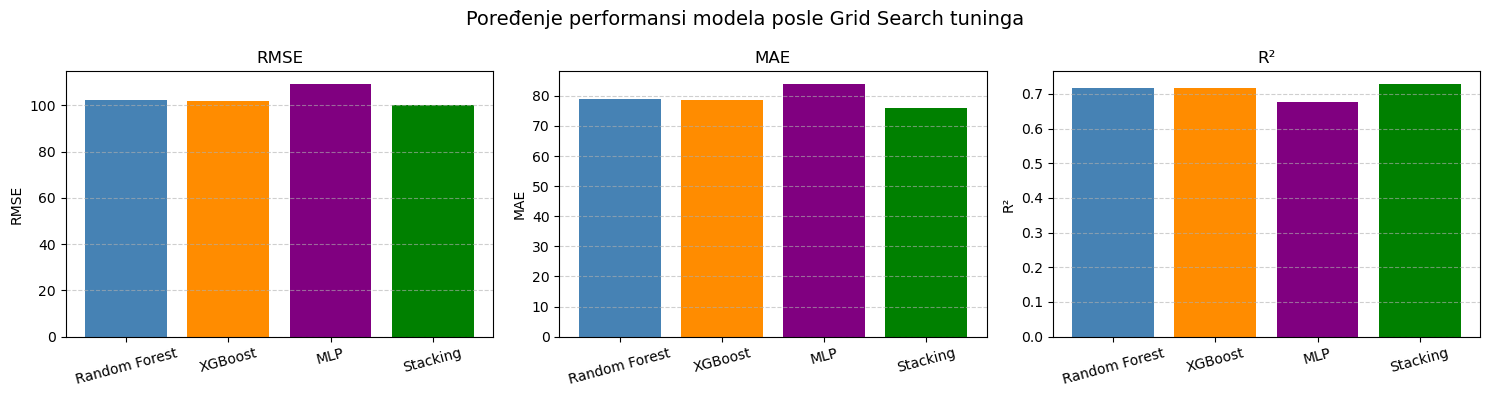

In [74]:
# === 26. Poređenje performansi modela posle Grid Search tuninga (uključujući Stacking) ===

results_tuned = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'MLP', 'Stacking'],
    'RMSE':  [rmse_rf_best, rmse_xgb_best, rmse_mlp_best, rmse_stack_best],
    'MAE':   [mae_rf_best, mae_xgb_best, mae_mlp_best, mae_stack_best],
    'R²':    [r2_rf_best, r2_xgb_best, r2_mlp_best, r2_stack_best]
})

display(results_tuned)

# === Grafički prikaz poređenja ===
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['RMSE', 'MAE', 'R²']
colors = ['steelblue', 'darkorange', 'purple', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(results_tuned['Model'], results_tuned[metric], color=colors)
    axes[i].set_title(metric, fontsize=12)
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("Poređenje performansi modela posle Grid Search tuninga", fontsize=14)
plt.tight_layout()
plt.show()


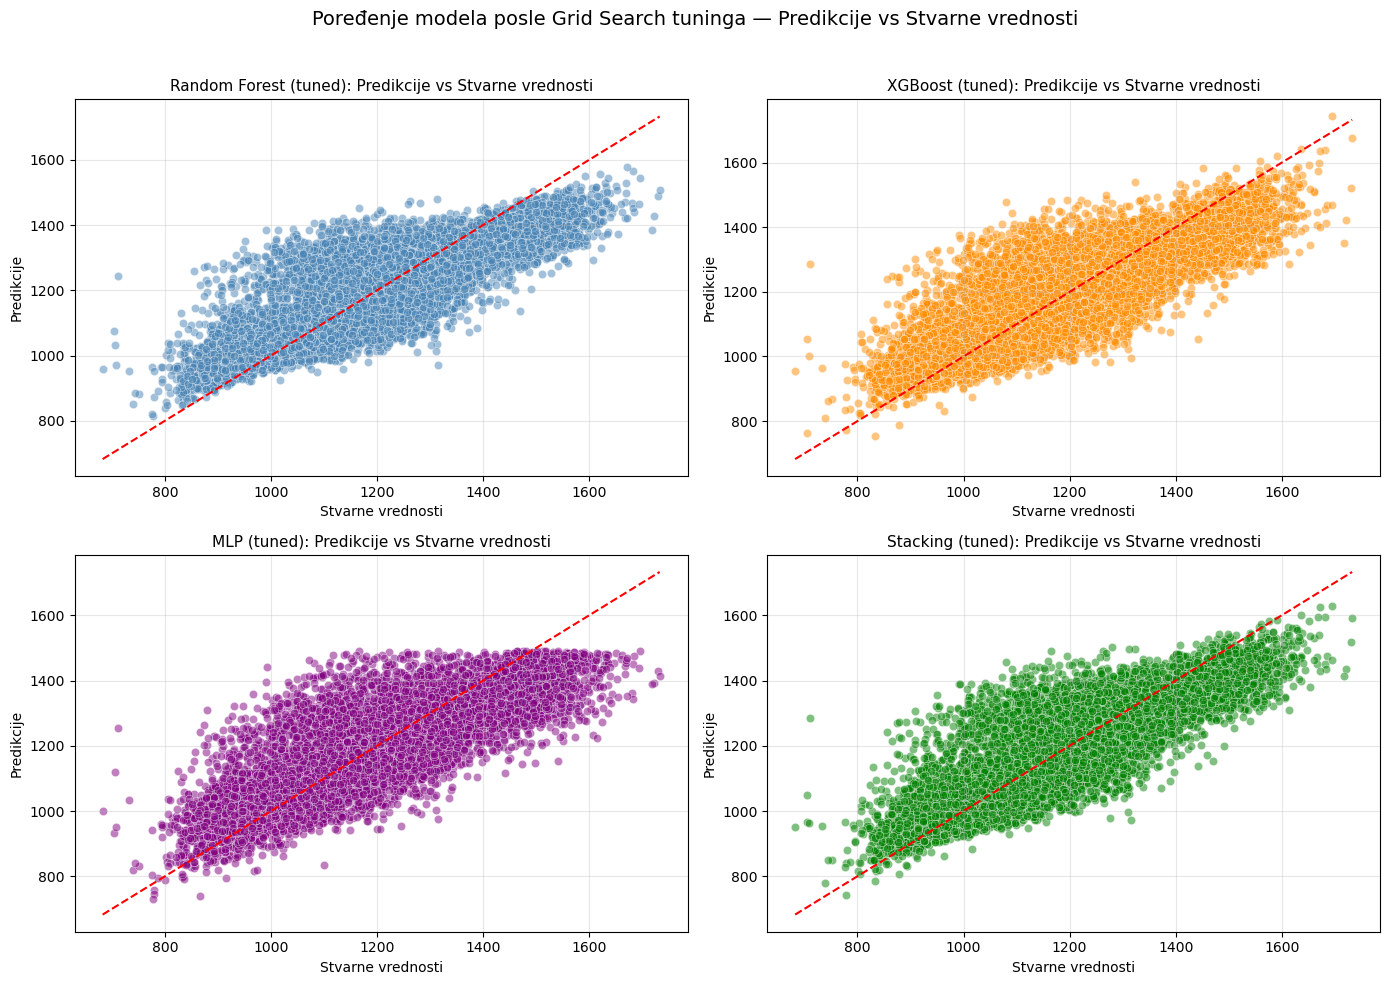

In [72]:
# === 27. Predikcije vs Stvarne vrednosti — modeli posle Grid Search tuninga (uključujući Stacking) ===

import matplotlib.pyplot as plt
import seaborn as sns

# Priprema figure (2 reda × 2 kolone)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Modeli i boje
models_best = [
    ("Random Forest (tuned)", y_pred_rf_best, 'steelblue'),
    ("XGBoost (tuned)", y_pred_xgb_best, 'darkorange'),
    ("MLP (tuned)", y_pred_mlp_best, 'purple'),
    ("Stacking (tuned)", y_pred_stack_best, 'green')
]

# Crtanje grafika
for i, (title, preds, color) in enumerate(models_best):
    sns.scatterplot(x=y_test, y=preds, alpha=0.5, color=color, ax=axes[i])
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[i].set_title(f"{title}: Predikcije vs Stvarne vrednosti", fontsize=11)
    axes[i].set_xlabel("Stvarne vrednosti")
    axes[i].set_ylabel("Predikcije")
    axes[i].grid(alpha=0.3)

plt.suptitle("Poređenje modela posle Grid Search tuninga — Predikcije vs Stvarne vrednosti", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


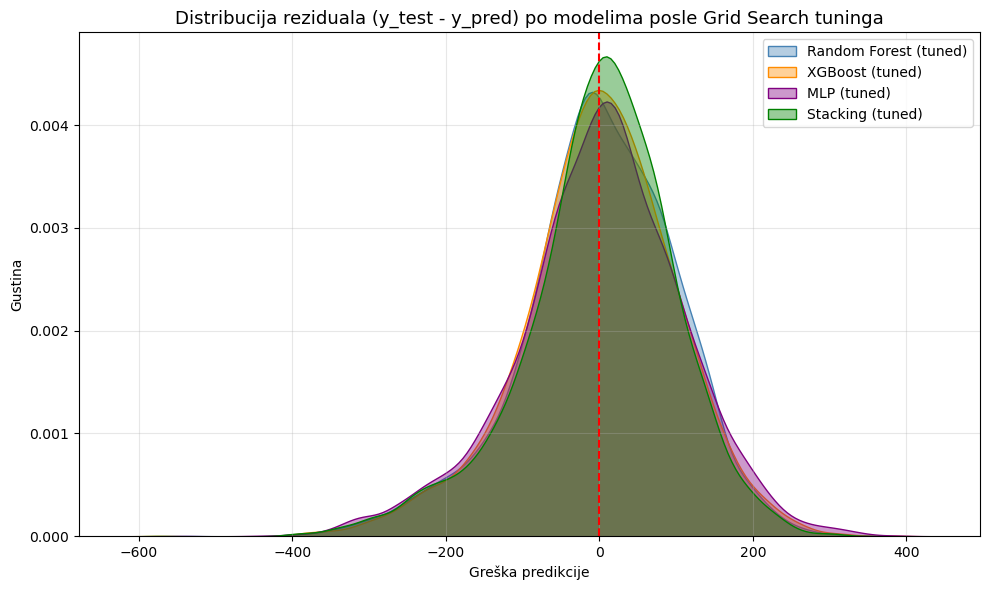

In [73]:
# === 28. Analiza reziduala (grešaka) po modelima posle Grid Search tuninga ===
import seaborn as sns
import matplotlib.pyplot as plt

# Izračunavanje reziduala (stvarno - predviđeno)
residuals_rf_best = y_test - y_pred_rf_best
residuals_xgb_best = y_test - y_pred_xgb_best
residuals_mlp_best = y_test - y_pred_mlp_best
residuals_stack_best = y_test - y_pred_stack_best

# Crtanje KDE distribucija
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_rf_best, label='Random Forest (tuned)', fill=True, alpha=0.4, color='steelblue')
sns.kdeplot(residuals_xgb_best, label='XGBoost (tuned)', fill=True, alpha=0.4, color='darkorange')
sns.kdeplot(residuals_mlp_best, label='MLP (tuned)', fill=True, alpha=0.4, color='purple')
sns.kdeplot(residuals_stack_best, label='Stacking (tuned)', fill=True, alpha=0.4, color='green')

# Linija nulte greške
plt.axvline(0, color='red', linestyle='--', lw=1.5)
plt.title("Distribucija reziduala (y_test - y_pred) po modelima posle Grid Search tuninga", fontsize=13)
plt.xlabel("Greška predikcije")
plt.ylabel("Gustina")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [75]:
# === 29. Randomized Search — Random Forest (prošireni raspon parametara) ===
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Pipeline (preprocessor + model)
rf_pipeline_rand = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(random_state=56))
])

# Širi raspon parametara nego kod Grid Searcha
rf_params_rand = {
    'rf__n_estimators': [100, 200, 300, 500, 700, 900],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

# Randomized Search (manje iteracija za brzinu)
rf_random = RandomizedSearchCV(
    rf_pipeline_rand,
    param_distributions=rf_params_rand,
    n_iter=40,  # dovoljno široko, ali ne predugo
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=56
)

# Treniranje modela
rf_random.fit(X_train, y_train)

# Najbolji model i parametri
rf_best_rand = rf_random.best_estimator_
print("\n=== Najbolji parametri RF (Randomized Search) ===")
print(rf_random.best_params_)

# Evaluacija
y_pred_rf_rand = rf_best_rand.predict(X_test)
rmse_rf_rand = np.sqrt(mean_squared_error(y_test, y_pred_rf_rand))
mae_rf_rand = mean_absolute_error(y_test, y_pred_rf_rand)
r2_rf_rand = r2_score(y_test, y_pred_rf_rand)

print("\n=== Performanse RF (Randomized Search) ===")
print(f"RMSE: {rmse_rf_rand:.3f}")
print(f"MAE:  {mae_rf_rand:.3f}")
print(f"R²:   {r2_rf_rand:.3f}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits

=== Najbolji parametri RF (Randomized Search) ===
{'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': None}

=== Performanse RF (Randomized Search) ===
RMSE: 103.640
MAE:  80.578
R²:   0.709


In [76]:
# === 30. Randomized Search — XGBoost (prošireni raspon parametara) ===
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Pipeline (preprocessor + model)
xgb_pipeline_rand = Pipeline([
    ('prep', preprocessor),
    ('xgb', XGBRegressor(
        random_state=56,
        objective='reg:squarederror',
        n_jobs=-1
    ))
])

# Širi, ali kontrolisan prostor parametara
xgb_params_rand = {
    'xgb__n_estimators': [100, 200, 300, 400, 500],
    'xgb__max_depth': [3, 4, 5, 6, 7, 8],
    'xgb__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__reg_alpha': [0, 0.001, 0.01, 0.1],
    'xgb__reg_lambda': [0.5, 1, 1.5, 2]
}

# Randomized Search
xgb_random = RandomizedSearchCV(
    xgb_pipeline_rand,
    param_distributions=xgb_params_rand,
    n_iter=35,  # dovoljan broj kombinacija, ali da ne traje predugo
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=56
)

# Treniranje
xgb_random.fit(X_train, y_train)

# Najbolji model i parametri
xgb_best_rand = xgb_random.best_estimator_
print("\n=== Najbolji parametri XGB (Randomized Search) ===")
print(xgb_random.best_params_)

# Evaluacija
y_pred_xgb_rand = xgb_best_rand.predict(X_test)
rmse_xgb_rand = np.sqrt(mean_squared_error(y_test, y_pred_xgb_rand))
mae_xgb_rand = mean_absolute_error(y_test, y_pred_xgb_rand)
r2_xgb_rand = r2_score(y_test, y_pred_xgb_rand)

print("\n=== Performanse XGB (Randomized Search) ===")
print(f"RMSE: {rmse_xgb_rand:.3f}")
print(f"MAE:  {mae_xgb_rand:.3f}")
print(f"R²:   {r2_xgb_rand:.3f}")


Fitting 3 folds for each of 35 candidates, totalling 105 fits

=== Najbolji parametri XGB (Randomized Search) ===
{'xgb__subsample': 0.6, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 300, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.9}

=== Performanse XGB (Randomized Search) ===
RMSE: 101.823
MAE:  78.357
R²:   0.719


In [77]:
# === 31. Randomized Search — MLP Regressor (prošireni raspon parametara) ===
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Pipeline (preprocessor + model)
mlp_pipeline_rand = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(random_state=56, max_iter=500))
])

# Prošireni ali razuman prostor parametara
mlp_params_rand = {
    'mlp__hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.05],
    'mlp__max_iter': [300, 500, 700]
}

# Randomized Search
mlp_random = RandomizedSearchCV(
    mlp_pipeline_rand,
    param_distributions=mlp_params_rand,
    n_iter=30,  # dovoljno bogato, ali ne predugo
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=56
)

# Treniranje modela
mlp_random.fit(X_train, y_train)

# Najbolji model i parametri
mlp_best_rand = mlp_random.best_estimator_
print("\n=== Najbolji parametri MLP (Randomized Search) ===")
print(mlp_random.best_params_)

# Evaluacija
y_pred_mlp_rand = mlp_best_rand.predict(X_test)
rmse_mlp_rand = np.sqrt(mean_squared_error(y_test, y_pred_mlp_rand))
mae_mlp_rand = mean_absolute_error(y_test, y_pred_mlp_rand)
r2_mlp_rand = r2_score(y_test, y_pred_mlp_rand)

print("\n=== Performanse MLP (Randomized Search) ===")
print(f"RMSE: {rmse_mlp_rand:.3f}")
print(f"MAE:  {mae_mlp_rand:.3f}")
print(f"R²:   {r2_mlp_rand:.3f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits

=== Najbolji parametri MLP (Randomized Search) ===
{'mlp__solver': 'adam', 'mlp__max_iter': 300, 'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (128, 64), 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}

=== Performanse MLP (Randomized Search) ===
RMSE: 110.369
MAE:  84.385
R²:   0.670


In [78]:
# === 32. Stacking Regressor (Randomized Search verzije modela) ===
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Bazni modeli — najbolje verzije iz Randomized Search-a
estimators_rand = [
    ('rf', rf_best_rand),
    ('xgb', xgb_best_rand),
    ('mlp', mlp_best_rand)
]

# Meta-model: Linearna regresija
stack_rand = StackingRegressor(
    estimators=estimators_rand,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

# Treniranje Stacking modela
stack_rand.fit(X_train, y_train)

# Predikcija
y_pred_stack_rand = stack_rand.predict(X_test)

# Evaluacija
rmse_stack_rand = np.sqrt(mean_squared_error(y_test, y_pred_stack_rand))
mae_stack_rand = mean_absolute_error(y_test, y_pred_stack_rand)
r2_stack_rand = r2_score(y_test, y_pred_stack_rand)

print("=== Stacking Regressor (Randomized Search) ===")
print(f"RMSE: {rmse_stack_rand:.3f}")
print(f"MAE:  {mae_stack_rand:.3f}")
print(f"R²:   {r2_stack_rand:.3f}")


=== Stacking Regressor (Randomized Search) ===
RMSE: 99.362
MAE:  75.600
R²:   0.732


Model        RMSE        MAE        R²
0  Random Forest  103.639929  80.577806  0.708757
1        XGBoost  101.822793  78.357168  0.718880
2            MLP  110.368728  84.385236  0.669712
3       Stacking   99.362179  75.599930  0.732303

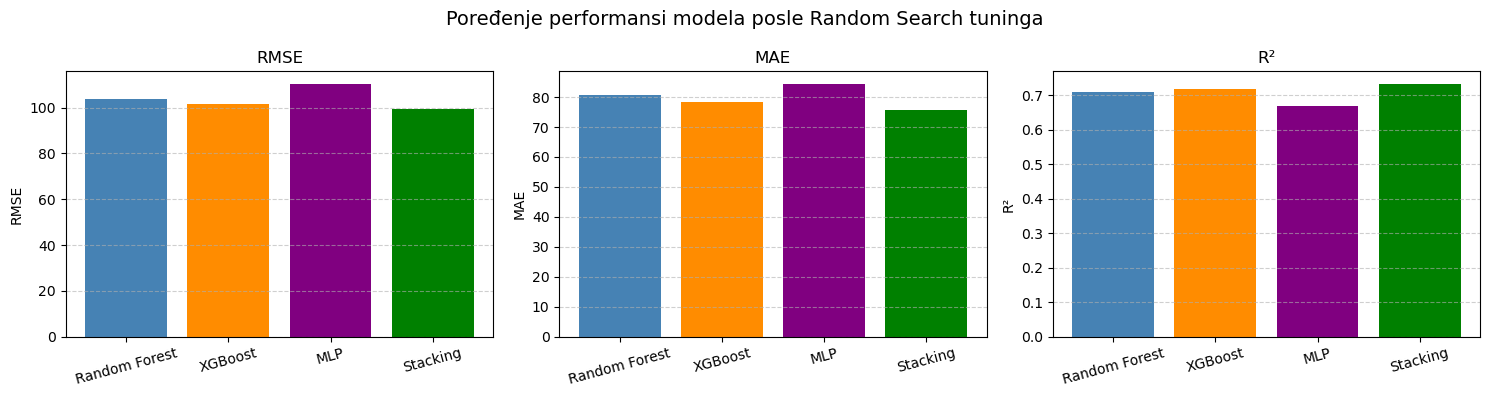

In [80]:
# === 33. Poređenje performansi modela posle Random Search tuninga ===

# Kreiranje DataFrame-a sa metrikama
results_rand = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'MLP', 'Stacking'],
    'RMSE':  [rmse_rf_rand, rmse_xgb_rand, rmse_mlp_rand, rmse_stack_rand],
    'MAE':   [mae_rf_rand, mae_xgb_rand, mae_mlp_rand, mae_stack_rand],
    'R²':    [r2_rf_rand, r2_xgb_rand, r2_mlp_rand, r2_stack_rand]
})

# Prikaz rezultata u tabeli
display(results_rand)

# === Grafički prikaz poređenja ===
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['RMSE', 'MAE', 'R²']
colors = ['steelblue', 'darkorange', 'purple', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(results_rand['Model'], results_rand[metric], color=colors)
    axes[i].set_title(metric, fontsize=12)
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("Poređenje performansi modela posle Random Search tuninga", fontsize=14)
plt.tight_layout()
plt.show()


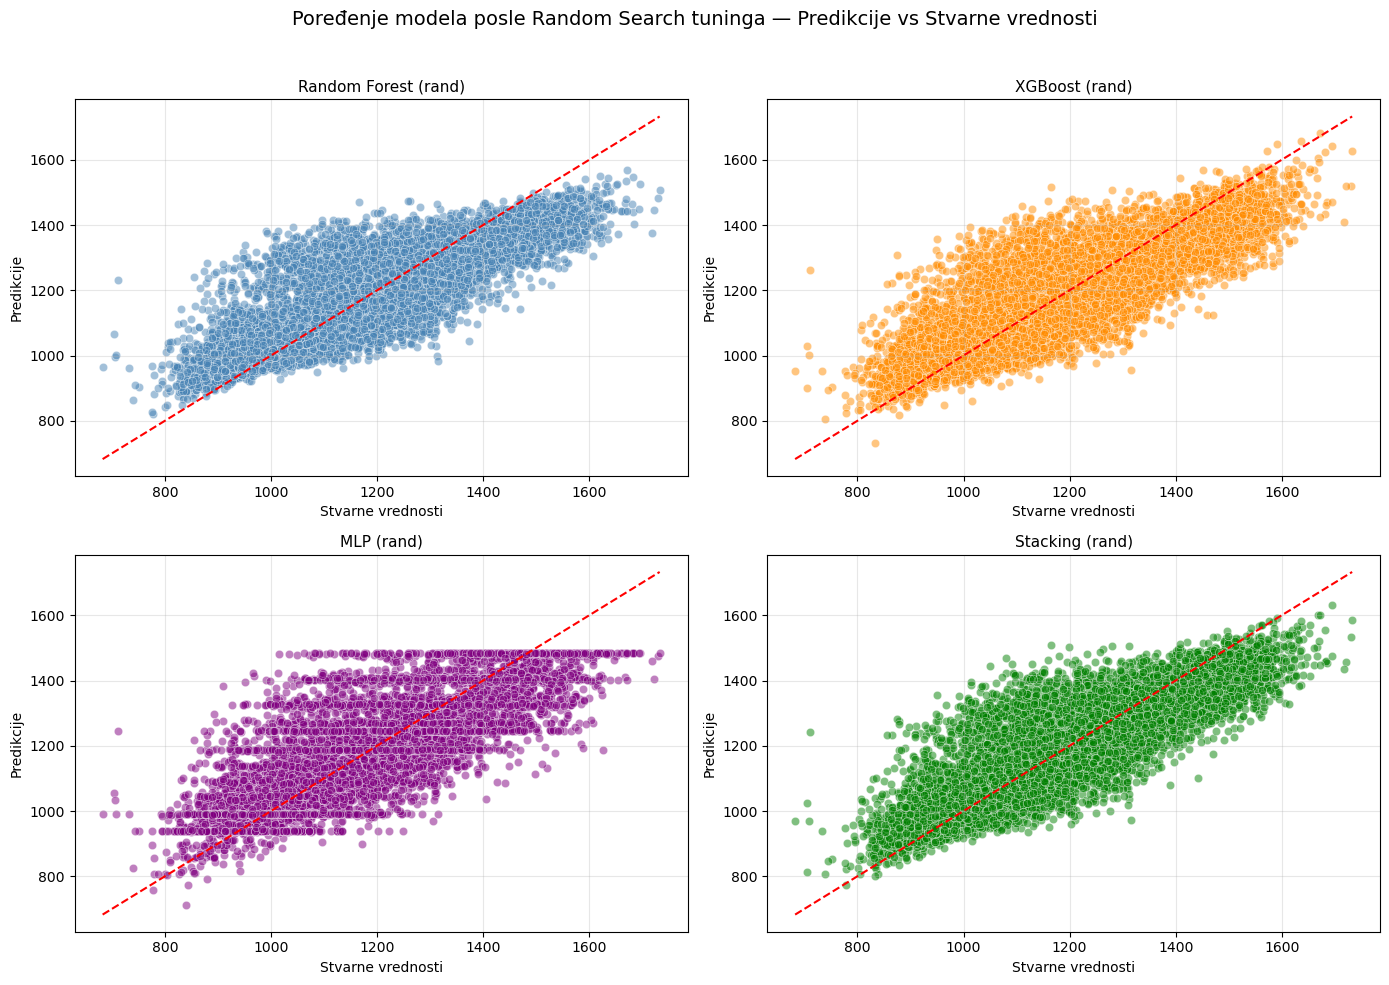

In [82]:
# === 34. Predikcije vs Stvarne vrednosti — modeli posle Random Search tuninga ===

import matplotlib.pyplot as plt
import seaborn as sns

# Priprema figure (2 reda × 2 kolone)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Modeli i njihove predikcije
models_rand = [
    ("Random Forest (rand)", y_pred_rf_rand, 'steelblue'),
    ("XGBoost (rand)", y_pred_xgb_rand, 'darkorange'),
    ("MLP (rand)", y_pred_mlp_rand, 'purple'),
    ("Stacking (rand)", y_pred_stack_rand, 'green')
]

# Crtanje scatter grafika za svaki model
for i, (title, preds, color) in enumerate(models_rand):
    sns.scatterplot(x=y_test, y=preds, alpha=0.5, color=color, ax=axes[i])
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[i].set_title(title, fontsize=11)
    axes[i].set_xlabel("Stvarne vrednosti")
    axes[i].set_ylabel("Predikcije")
    axes[i].grid(alpha=0.3)

plt.suptitle("Poređenje modela posle Random Search tuninga — Predikcije vs Stvarne vrednosti", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


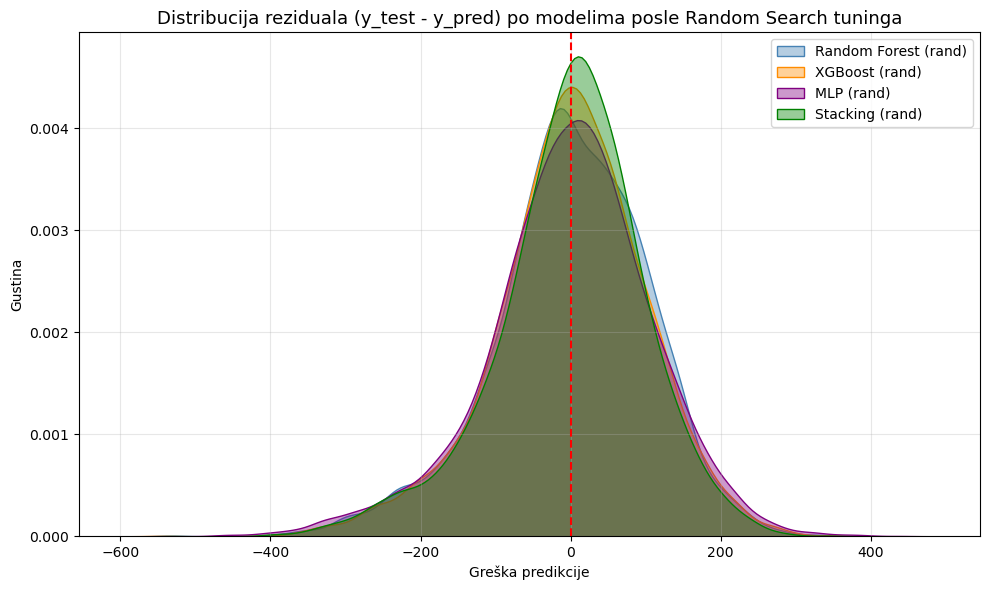

In [83]:
# === 35. Analiza reziduala (grešaka) po modelima posle Random Search tuninga ===
import seaborn as sns
import matplotlib.pyplot as plt

# Izračunavanje reziduala (stvarno - predviđeno)
residuals_rf_rand = y_test - y_pred_rf_rand
residuals_xgb_rand = y_test - y_pred_xgb_rand
residuals_mlp_rand = y_test - y_pred_mlp_rand
residuals_stack_rand = y_test - y_pred_stack_rand

# Crtanje KDE distribucija
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_rf_rand, label='Random Forest (rand)', fill=True, alpha=0.4, color='steelblue')
sns.kdeplot(residuals_xgb_rand, label='XGBoost (rand)', fill=True, alpha=0.4, color='darkorange')
sns.kdeplot(residuals_mlp_rand, label='MLP (rand)', fill=True, alpha=0.4, color='purple')
sns.kdeplot(residuals_stack_rand, label='Stacking (rand)', fill=True, alpha=0.4, color='green')

# Linija nulte greške
plt.axvline(0, color='red', linestyle='--', lw=1.5)
plt.title("Distribucija reziduala (y_test - y_pred) po modelima posle Random Search tuninga", fontsize=13)
plt.xlabel("Greška predikcije")
plt.ylabel("Gustina")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [84]:
# === 36. Chain Forward Cross-Validation (5 foldova) za sve modele ===
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Koristi trenirajući deo podataka
X_data, y_data = X_train, y_train

# 5 uzastopnih foldova (forward chaining)
tscv = TimeSeriesSplit(n_splits=5)

# Priprema modela koje testiramo
models_cv = {
    "Random Forest (rand)": rf_best_rand,
    "XGBoost (rand)": xgb_best_rand,
    "MLP (rand)": mlp_best_rand,
    "Stacking (rand)": stack_rand
}

# Mesto za rezultate
cv_results = []

# Evaluacija svakog modela kroz 5 foldova
for name, model in models_cv.items():
    rmse_list, mae_list, r2_list = [], [], []
    
    print(f"\nEvaluacija modela: {name}")
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X_data)):
        X_train_fold, X_test_fold = X_data.iloc[train_index], X_data.iloc[test_index]
        y_train_fold, y_test_fold = y_data.iloc[train_index], y_data.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))
        mae_list.append(mean_absolute_error(y_test_fold, y_pred_fold))
        r2_list.append(r2_score(y_test_fold, y_pred_fold))

        print(f"  Fold {fold+1} → RMSE: {rmse_list[-1]:.3f}, R²: {r2_list[-1]:.3f}")

    # Prosečne metrike za model
    cv_results.append({
        "Model": name,
        "CV_RMSE": np.mean(rmse_list),
        "CV_MAE": np.mean(mae_list),
        "CV_R²": np.mean(r2_list)
    })

# Tabela rezultata
cv_results_df = pd.DataFrame(cv_results)
display(cv_results_df)



Evaluacija modela: Random Forest (rand)
  Fold 1 → RMSE: 118.620, R²: 0.609
  Fold 2 → RMSE: 114.446, R²: 0.641
  Fold 3 → RMSE: 111.254, R²: 0.667
  Fold 4 → RMSE: 109.395, R²: 0.678
  Fold 5 → RMSE: 106.700, R²: 0.697

Evaluacija modela: XGBoost (rand)
  Fold 1 → RMSE: 119.951, R²: 0.600
  Fold 2 → RMSE: 114.136, R²: 0.643
  Fold 3 → RMSE: 109.275, R²: 0.679
  Fold 4 → RMSE: 106.352, R²: 0.695
  Fold 5 → RMSE: 104.741, R²: 0.708

Evaluacija modela: MLP (rand)
  Fold 1 → RMSE: 124.473, R²: 0.569
  Fold 2 → RMSE: 191.029, R²: -0.000
  Fold 3 → RMSE: 115.915, R²: 0.639
  Fold 4 → RMSE: 115.842, R²: 0.639
  Fold 5 → RMSE: 112.142, R²: 0.665

Evaluacija modela: Stacking (rand)
  Fold 1 → RMSE: 116.774, R²: 0.621
  Fold 2 → RMSE: 111.996, R²: 0.656
  Fold 3 → RMSE: 106.351, R²: 0.696
  Fold 4 → RMSE: 104.792, R²: 0.704
  Fold 5 → RMSE: 102.515, R²: 0.720


Model     CV_RMSE      CV_MAE     CV_R²
0  Random Forest (rand)  112.083052   87.392503  0.658353
1        XGBoost (rand)  110.890953   84.790855  0.665065
2            MLP (rand)  131.880279  103.732390  0.502359
3       Stacking (rand)  108.485614   83.062942  0.679519

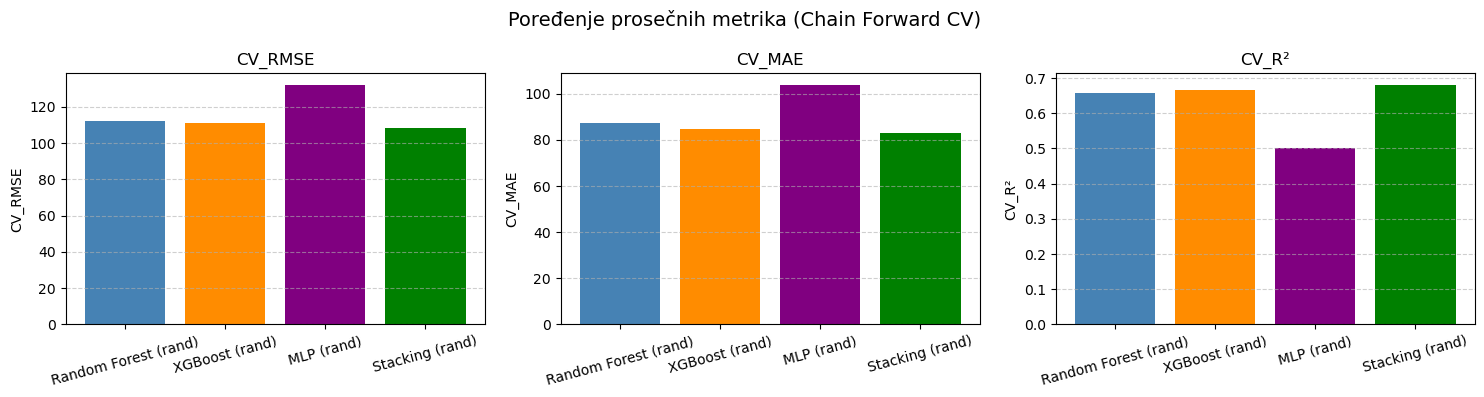

In [85]:
# === 37. Grafičko poređenje performansi modela iz Chain Forward Cross-Validation ===

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['CV_RMSE', 'CV_MAE', 'CV_R²']
colors = ['steelblue', 'darkorange', 'purple', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(cv_results_df['Model'], cv_results_df[metric], color=colors)
    axes[i].set_title(metric, fontsize=12)
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("Poređenje prosečnih metrika (Chain Forward CV)", fontsize=14)
plt.tight_layout()
plt.show()


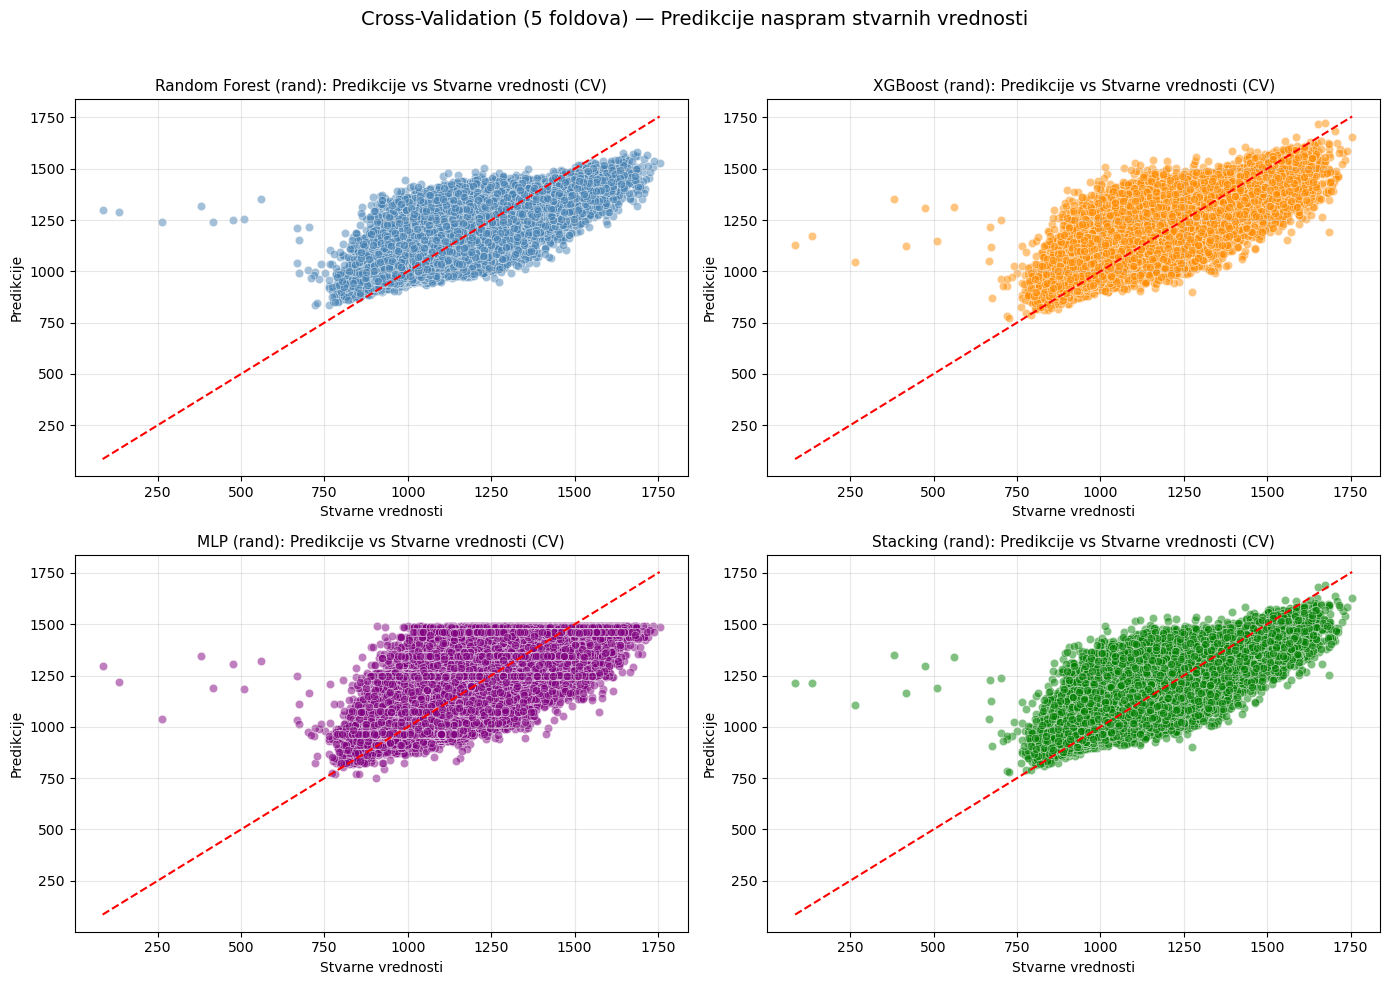

In [86]:
# === 38. Predikcije vs Stvarne vrednosti — Cross-Validation (5 foldova) ===
from sklearn.model_selection import cross_val_predict

# Modeli koje analiziramo (isti kao u CV)
models_cv_pred = {
    "Random Forest (rand)": rf_best_rand,
    "XGBoost (rand)": xgb_best_rand,
    "MLP (rand)": mlp_best_rand,
    "Stacking (rand)": stack_rand
}

# Figure 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Boje po modelima
colors = ['steelblue', 'darkorange', 'purple', 'green']

# Cross-val predikcije i grafici
for i, (name, model) in enumerate(models_cv_pred.items()):
    y_pred_cv = cross_val_predict(model, X_data, y_data, cv=5, n_jobs=-1)
    sns.scatterplot(x=y_data, y=y_pred_cv, alpha=0.5, color=colors[i], ax=axes[i])
    axes[i].plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'r--')
    axes[i].set_title(f"{name}: Predikcije vs Stvarne vrednosti (CV)", fontsize=11)
    axes[i].set_xlabel("Stvarne vrednosti")
    axes[i].set_ylabel("Predikcije")
    axes[i].grid(alpha=0.3)

plt.suptitle("Cross-Validation (5 foldova) — Predikcije naspram stvarnih vrednosti", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [87]:
# === 39. Poređenje performansi modela na trening i test skupu ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Definiši sve finalne modele (Random Search verzije + Stacking)
models_final = {
    "Random Forest (rand)": rf_best_rand,
    "XGBoost (rand)": xgb_best_rand,
    "MLP (rand)": mlp_best_rand,
    "Stacking (rand)": stack_rand
}

# Prazna lista za rezultate
results_train_test = []

# Izračunaj metrike za svaki model
for name, model in models_final.items():
    # Treniranje modela (ako već nije treniran)
    model.fit(X_train, y_train)
    
    # Predikcije
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    # Metrike
    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test  = mean_absolute_error(y_test, y_test_pred)
    
    results_train_test.append({
        "Model": name,
        "Train_R²": r2_train,
        "Test_R²": r2_test,
        "Train_RMSE": rmse_train,
        "Test_RMSE": rmse_test,
        "Train_MAE": mae_train,
        "Test_MAE": mae_test
    })

# Prikaz tabele
results_train_test_df = pd.DataFrame(results_train_test)
display(results_train_test_df)


Model  Train_R²   Test_R²  Train_RMSE   Test_RMSE  \
0  Random Forest (rand)  0.932798  0.708757   49.790545  103.639929   
1        XGBoost (rand)  0.908566  0.718880   58.077678  101.822793   
2            MLP (rand)  0.754561  0.669712   95.154089  110.368728   
3       Stacking (rand)  0.907616  0.732303   58.378548   99.362179   

   Train_MAE   Test_MAE  
0  37.737939  80.577806  
1  43.772883  78.357168  
2  71.800659  84.385236  
3  43.610758  75.599930

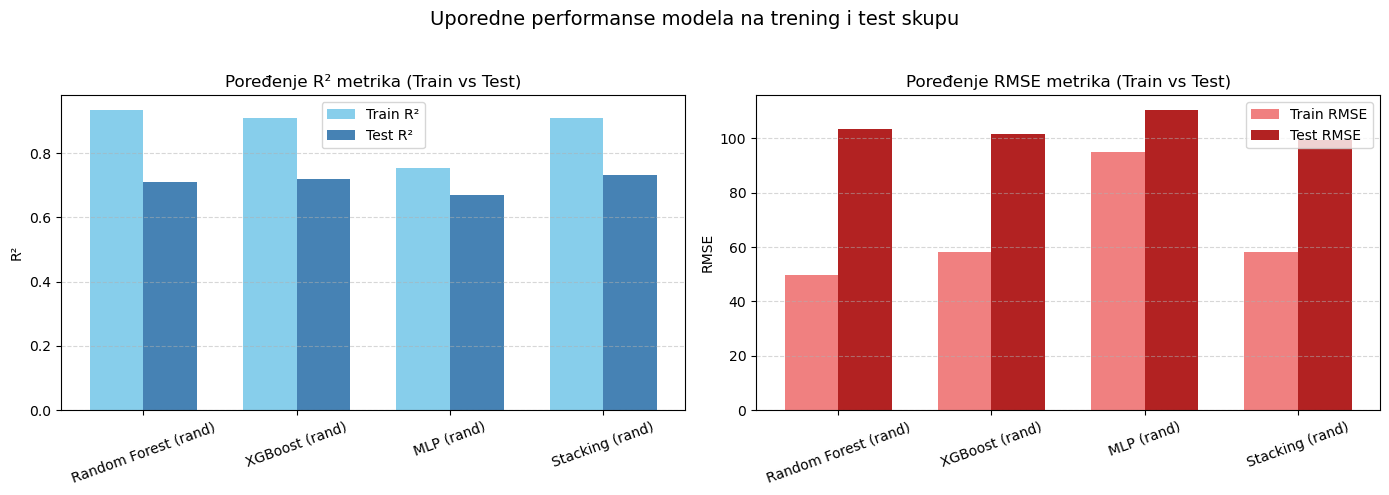

In [88]:
# === 40. Grafičko poređenje performansi (Train vs Test) ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bar_width = 0.35
models = results_train_test_df["Model"]
x = np.arange(len(models))

# --- 1️⃣ R² poređenje ---
axes[0].bar(x - bar_width/2, results_train_test_df["Train_R²"], 
            width=bar_width, label="Train R²", color="skyblue")
axes[0].bar(x + bar_width/2, results_train_test_df["Test_R²"], 
            width=bar_width, label="Test R²", color="steelblue")
axes[0].set_title("Poređenje R² metrika (Train vs Test)", fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=20)
axes[0].set_ylabel("R²")
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# --- 2️⃣ RMSE poređenje ---
axes[1].bar(x - bar_width/2, results_train_test_df["Train_RMSE"], 
            width=bar_width, label="Train RMSE", color="lightcoral")
axes[1].bar(x + bar_width/2, results_train_test_df["Test_RMSE"], 
            width=bar_width, label="Test RMSE", color="firebrick")
axes[1].set_title("Poređenje RMSE metrika (Train vs Test)", fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=20)
axes[1].set_ylabel("RMSE")
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Uporedne performanse modela na trening i test skupu", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


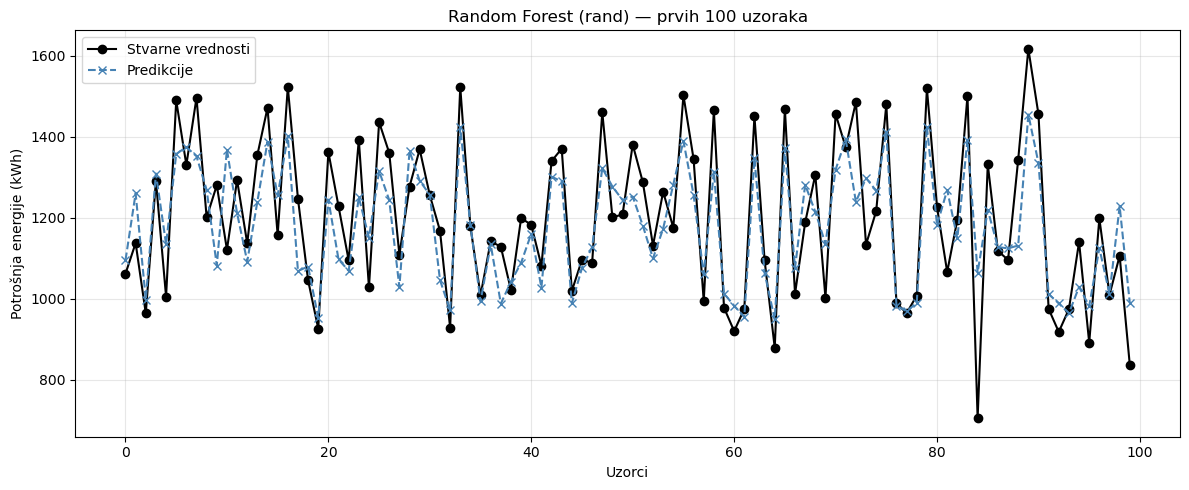

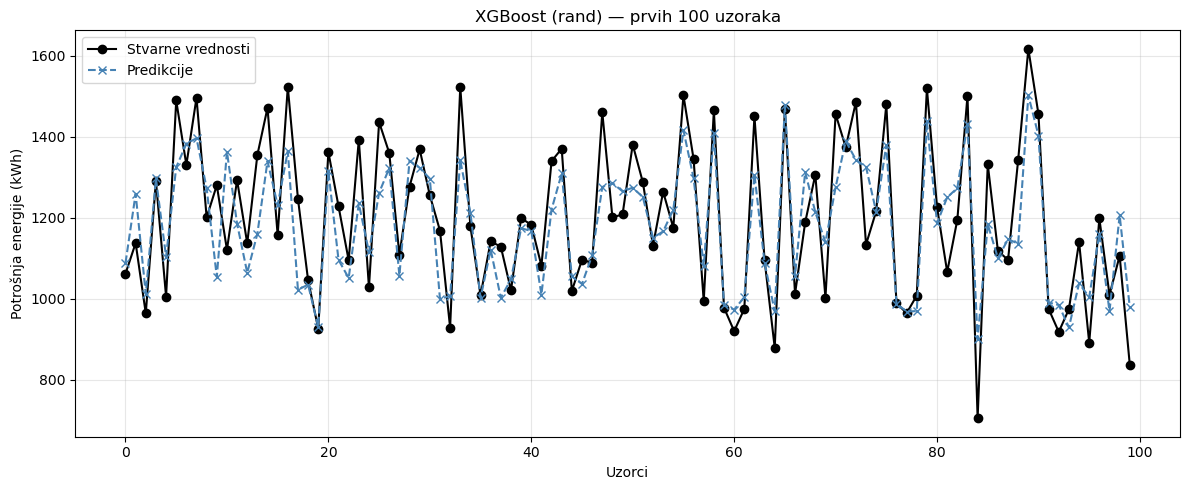

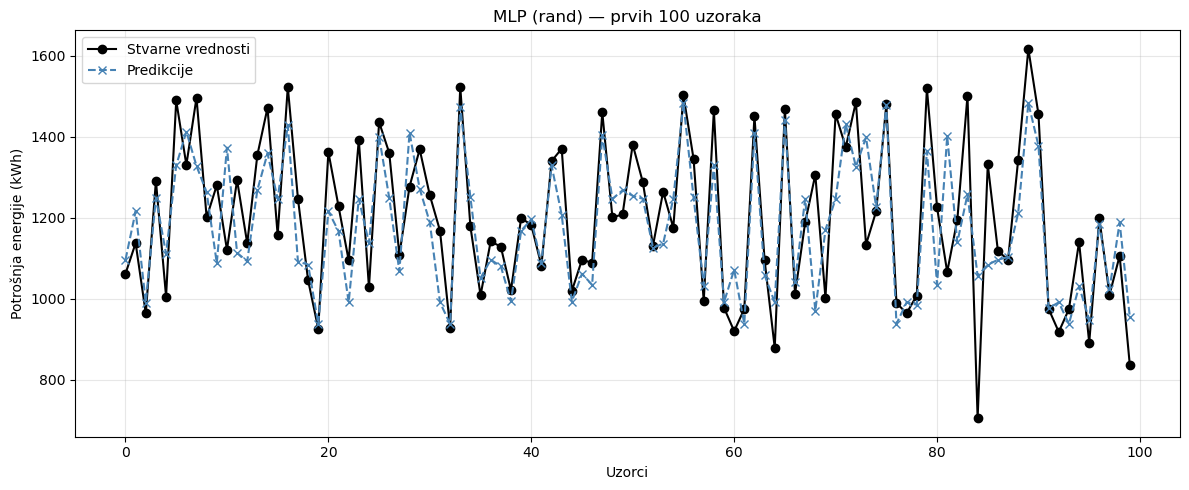

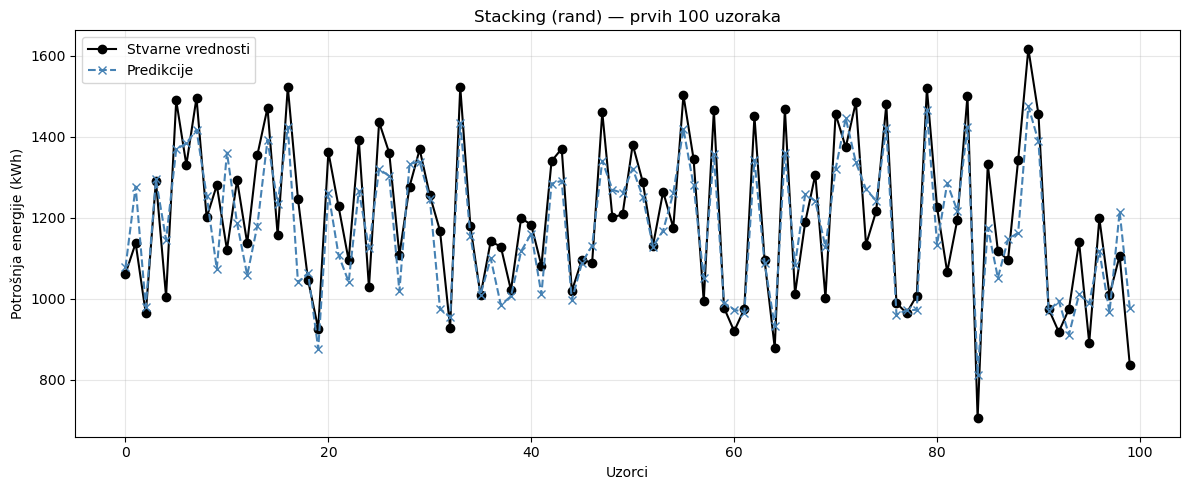

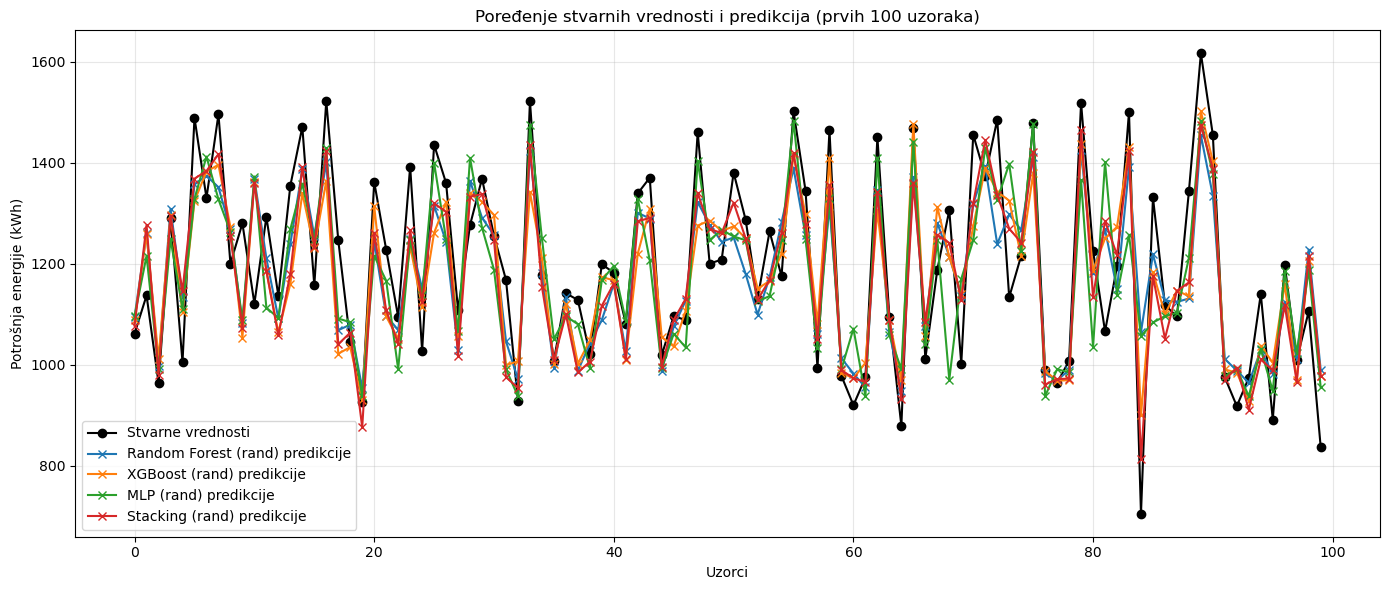

In [90]:
import matplotlib.pyplot as plt

# === 41. Funkcija za prikaz predikcija i stvarnih vrednosti ===
def plot_predictions(y_true, y_pred, title, n_samples=100):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true.values[:n_samples], label="Stvarne vrednosti", marker='o', color='black')
    plt.plot(y_pred[:n_samples], label="Predikcije", marker='x', linestyle='--', color='steelblue')
    plt.legend()
    plt.title(f"{title} — prvih {n_samples} uzoraka")
    plt.xlabel("Uzorci")
    plt.ylabel("Potrošnja energije (kWh)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Prikaz po modelima ===
models_final = {
    "Random Forest (rand)": rf_best_rand,
    "XGBoost (rand)": xgb_best_rand,
    "MLP (rand)": mlp_best_rand,
    "Stacking (rand)": stack_rand
}

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    plot_predictions(y_test, y_pred, title=name, n_samples=100)

# === Zajednički grafik za svih 100 uzoraka ===
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:100], label="Stvarne vrednosti", marker='o', color="black")

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    plt.plot(y_pred[:100], label=f"{name} predikcije", marker='x')

plt.legend()
plt.title("Poređenje stvarnih vrednosti i predikcija (prvih 100 uzoraka)")
plt.xlabel("Uzorci")
plt.ylabel("Potrošnja energije (kWh)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [91]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# === 42. Filtriranje podataka do kraja 2018. godine ===
df_no_covid = df[df['datetime'] < '2019-01-01'].copy()
print("Dimenzije nakon filtriranja:", df_no_covid.shape)

# === 2. Definisanje X i y ponovo ===
X_no_covid = df_no_covid[num_features + cat_features]
y_no_covid = df_no_covid['nat_demand']

# === 3. Podela na train/test (npr. 80/20) ===
from sklearn.model_selection import train_test_split
X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(
    X_no_covid, y_no_covid, test_size=0.2, random_state=56
)

# === 4. Standardizacija i enkodovanje (isti preprocessor) ===
X_train_nc_trans = preprocessor.fit_transform(X_train_nc)
X_test_nc_trans  = preprocessor.transform(X_test_nc)

# === 5. Treniranje XGBoost modela ===
xgb_nc = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=56,
    objective='reg:squarederror'
)

xgb_nc.fit(X_train_nc_trans, y_train_nc)
y_pred_nc = xgb_nc.predict(X_test_nc_trans)

# === 6. Evaluacija performansi ===
rmse_nc = np.sqrt(mean_squared_error(y_test_nc, y_pred_nc))
mae_nc = mean_absolute_error(y_test_nc, y_pred_nc)
r2_nc = r2_score(y_test_nc, y_pred_nc)

print("\n=== XGBoost model (bez 2019–2020 podataka) ===")
print(f"RMSE: {rmse_nc:.3f}")
print(f"MAE:  {mae_nc:.3f}")
print(f"R²:   {r2_nc:.3f}")


Dimenzije nakon filtriranja: (35015, 17)

=== XGBoost model (bez 2019–2020 podataka) ===
RMSE: 106.065
MAE:  83.026
R²:   0.688
